![oi_masterdados](img/oi_masterdados2.png)

# Job Change of Data Scientists

## Este projeto tem o propósito de predizer quem irá mudar para um novo emprego. Para isso, utilizaremos um modelo de classificação supervisionado.

# GRUPO 02

## ●  Iura Teixeira Xavier
## ●  Adames Oliveira
## ●  Fabyo Sousa Ramos

# CRISP-DM METHODOLOGY - Cross Industry Standard Process for Data Mining


### CRISP-DM is a data mining methodology in cyclic format, which guide the discovery of knowledge for decision making on large volume data.

![Crisp 1](img/crisp1.jpg)

# DATASET

https://www.kaggle.com/datasets/arashnic/hr-analytics-job-change-of-data-scientists

## Job Change of Data Scientists

Uma empresa que atua em Big Data e Data Science deseja contratar cientistas de dados entre as pessoas que passam com sucesso em alguns cursos ministrados pela empresa.

Muitas pessoas se inscrevem para o seu treinamento. A Empresa quer saber quais destes candidatos estão realmente propensos a trabalhar para a empresa após a formação, pois isso ajuda a reduzir o custo e tempo, bem como a qualidade da formação ou planejamento dos cursos e categorização dos candidatos.

Informações relacionadas a demografia, educação, experiência estão em mãos desde a inscrição e inscrição dos candidatos.

## Features

●  **enrollee_id** : ID do candidato

●  **city:** Código da cidade

●  **city_ development _index** :** Índice de desenvolvimento urbano.

●  **gender:** Gênero do candidato.

●  **relevent_experience:** Experiência do candidato.

●  **enrolled_university:** Se está matriculado em alguma universidade.

●  **education_level:** Grau de educação do candidato.

●  **major_discipline** :** Área de educação do candidato.

●  **experience:** Candidate total **- experience in years

●  **company_size:** Número de empregados da empresa em que o candidato trabalha.

●  **company_type** :** Tipo de negócio da empresa em que o candidato trabalha.

●  **lastnewjob:** Diferença em anos entre o emprego anterior e o atual.

●  **training_hours:** Quantidade de tempo de treinamento do candidato.

●  **target:** 0 – Não está a procura de um novo emprego, 1 – Está a procura de um novo emprego.

## Objetivo

### Identificar candidato propensos a trabalhar para a empresa.

# 0.0 IMPORTS

In [666]:
import collections
import datetime
import imblearn
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

from datetime                import timedelta
from IPython.display         import Image
from IPython.core.display    import HTML
from scipy                   import stats as ss
from scipy.stats             import ks_2samp
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble        import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.tree            import DecisionTreeClassifier
from sklearn.metrics         import accuracy_score, confusion_matrix, classification_report, balanced_accuracy_score, cohen_kappa_score, roc_curve, roc_auc_score, matthews_corrcoef
from sklearn.naive_bayes     import GaussianNB
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.svm             import SVC
from sklearn.neural_network  import MLPClassifier
from xgboost                 import XGBClassifier, XGBRFClassifier
from imblearn.over_sampling  import SMOTE
from imblearn.combine        import SMOTETomek

warnings.filterwarnings('ignore')

# 1.0 HELPER FUNCTIONS

In [667]:
def check_nan(df):
    '''
    Takes df
    Checks nulls
    '''
    nan_cols = [i for i in df.columns if df[i].isnull().any()]
    if df.isnull().sum().sum() > 0:
        mask_total = df.isnull().sum().sort_values(ascending=False) 
        total = mask_total[mask_total > 0]

        mask_percent = df.isnull().mean().sort_values(ascending=False) 
        percent = mask_percent[mask_percent > 0]
        
        missing_data = pd.concat([total, percent*100], axis=1, keys=['Total Missing', 'Percent'])
  
        print('● Dataset contains NaN values.\n')
        print(f'Total and Percentage of NaN:\n {missing_data}')
    else: 
        print('● Dataset does not contains NaN values. No NaN found.')
        
    return nan_cols

def cramer_v(x, y):
    cm = pd.crosstab(x,y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    chi2_corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    k_corr = k - (k-1)**2/(n-1)
    r_corr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2_corr/n) / ( min( k_corr-1, r_corr-1) ) )

def plot_roc_curve(fpr, tpr, auc):
    plt.plot(fpr, tpr)
    plt.title('ROC Curve - AUC: {}'.format(auc))
    plt.xlabel('1 - Especificidade (FPR)')
    plt.ylabel('Sensibilidade (TPR)')
    plt.grid(True)
    plt.show()


def udf_cross_validation(X_train, y_train, classifier_name, classifier, num_folds, n_repeats, verbose=False):
    inicio            = time.time()
    i                 = 1
    accuracy_list     = []
    balanced_acc_list = []
    kappa_acc_list    = []
    conf_matrix       = []
    mcc_list          = []
    auc_list          = []
    fpr_list          = []
    tpr_list          = []
    thresholds_list   = []        
    rskf              = RepeatedStratifiedKFold(n_splits=num_folds, n_repeats=n_repeats, random_state=36851234)
    
    # generate k-fold
    for train_idx, val_idx in rskf.split( X_train, y_train ):
        if verbose:
            print( '\n****** Running {}/{} ******'.format(i, n_repeats*num_folds) )
            
        # get training fold
        X_train_fold = X_train.iloc[train_idx]
        y_train_fold = y_train.iloc[train_idx].values.ravel()
        
        # get validation fold
        X_val_fold = X_train.iloc[val_idx]
        y_val_fold = y_train.iloc[val_idx]

        # training model
        classifier.fit(X_train_fold, y_train_fold)

        # predicting
        y_pred  = classifier.predict(X_val_fold)
        y_proba = classifier.predict_proba(X_val_fold)
        
        # metrics
        ## accuracy_score - Total of corrects predictions, main diagonal of the confusion matrix DIVIDED by the total of predictions
        score = accuracy_score(y_val_fold, y_pred)
        accuracy_list.append(score)
        
        ## Balanced Accuracy - Very goog to multi class analyses. Get all classes accuracy and extract the average. 
        balanced_acc = balanced_accuracy_score(y_val_fold, y_pred)
        balanced_acc_list.append(balanced_acc)
        
        ## Kappa score
        kappa_acc = cohen_kappa_score( y_val_fold, y_pred )
        kappa_acc_list.append(kappa_acc)
        
        # matthews_corrcoef - First, It is a metric that takes into account all the possibilities of a binary classification problem (TP, TN, FP and FN).
        #                            It is robust to unbalanced datasets. The result of it is a normalized coefficient between -1 and 1 that is easy to interpret.
        #
        #                            -1 : the closer your MCC is to -1, the worse your classifier is. In other words, he is making more mistakes than he gets right.
        #                            +1 : on the other hand, the closer to +1, the better your classifier. That is, he is hitting more than he misses.
        #                             0 : when the coefficient is close to 0, it shows that the classifier is just "kicking" the most frequent class (es).
        
        mcc = matthews_corrcoef( y_val_fold, y_pred )
        mcc_list.append( mcc )
        
        ## roc curve
        y_proba = y_proba[:, 1]
        auc = roc_auc_score(y_val_fold, y_proba)
        fpr, tpr, thresholds = roc_curve(y_val_fold, y_proba)
        auc_list.append(auc)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        thresholds_list.append(thresholds)
        
        conf_matrix.append( confusion_matrix(y_val_fold, y_pred) ) 
        i+=1
        
    # metrics ------------------------------------------------------------------------------------------------------
    
    # confusion matrix
    cnf_matrix = np.mean(conf_matrix, axis=0)
    TP = cnf_matrix[1,1]
    TN = cnf_matrix[0,0]
    FP = cnf_matrix[0,1]
    FN = cnf_matrix[1,0]
    
    # Precision, mede a proporção de predições positivas que estão corretas, ou seja, quão bem o modelo predisse os valores positivos.
    precision = TP / ( TP + FP ) 
    
    # Recall, True Positive Rate (TPR) ou Sensitividade. Mede uma proporção dos valores que são de fato positivos e que foram preditos corretamente.Recall is quite important when you want to minimise the case of FN.
    recall = TP / ( TP + FN )
    
    # F1 Score
    F1 = 2 * (precision * recall) / (precision + recall)
    
    # Specificity - How good the algorithm is at hitting the negative class. In other words: "Of the negative samples, how many did the algorithm get right?
    specificity = TN / ( TN+FP )

    # NPV - Negative Predictive Value - How much you trust the negative class prediction. In other words: “Of the samples that my algorithm said were negative, how many really are?
    npv = TN / (TN + FN)
    
    # plot confusion matrix
    udf_plot_confusion_matrix(cnf_matrix, [0, 1], normalize=False)
    
    # plot roc curve
    plot_roc_curve(fpr, tpr, np.round( np.mean(auc_list), 2 ).astype(str))

    #print( 'Confusion matrix:\n{}\n'.format( cnf_matrix ) )
    
    fim = time.time()
    
    df_classifier_result = pd.DataFrame(
        {
            'Classifier Name'                  : classifier_name,
            'Tempo de execução (s):'           : fim-inicio,
            'Accuracy score'                   : np.round( np.mean(accuracy_list), 2 ).astype(str),
            'Precision score'                  : np.round( precision, 2 ).astype(str),
            'Recall score'                     : np.round( recall, 2 ).astype(str),
            'F1 score'                         : np.round( F1, 2 ).astype(str),
            'Specificity'                      : np.round( specificity, 2 ).astype(str),
            'NPV'                              : np.round( npv, 2 ).astype(str),
            'Balanced Accuracy score'          : np.round( np.mean(balanced_acc_list), 2 ).astype(str),
            'AUC'                              : np.round( np.mean(auc_list), 2 ).astype(str),
            'Kappa score'                      : np.round( np.mean(kappa_acc_list), 2 ).astype(str),
            'Matthews Correlation Coefficient' : np.round( np.mean(mcc_list), 2 ).astype(str)
        },
        index=[0]
    )
        
    return df_classifier_result

def test_dataset_metrics(X_test_dataset, y_test_dataset, classifier, classifier_name):
    inicio  = time.time()
    y_pred  = classifier.predict(X_test_dataset)
    y_proba = classifier.predict_proba(X_test_dataset)
    
    # ----------------------------------------------------------------------------
    # metrics
    # ----------------------------------------------------------------------------

    ## accuracy_score - Total of corrects predictions, main diagonal of the confusion matrix DIVIDED by the total of predictions
    score = accuracy_score(y_test_dataset, y_pred)

    ## Balanced Accuracy - Very good to multi class analyses. Get all classes accuracy and extract the average. 
    balanced_acc = balanced_accuracy_score(y_test_dataset, y_pred)

    ## Kappa score
    kappa_acc = cohen_kappa_score( y_test_dataset, y_pred )

    # matthews_corrcoef - First, It is a metric that takes into account all the possibilities of a binary classification problem (TP, TN, FP and FN).
    #                            It is robust to unbalanced datasets. The result of it is a normalized coefficient between -1 and 1 that is easy to interpret.
    #
    #                            -1 : the closer your MCC is to -1, the worse your classifier is. In other words, he is making more mistakes than he gets right.
    #                            +1 : on the other hand, the closer to +1, the better your classifier. That is, he is hitting more than he misses.
    #                             0 : when the coefficient is close to 0, it shows that the classifier is just "kicking" the most frequent class (es).

    mcc = matthews_corrcoef( y_test_dataset, y_pred )

    ## roc curve
    y_proba = y_proba[:, 1]
    auc = roc_auc_score(y_test_dataset, y_proba)
    fpr, tpr, thresholds = roc_curve(y_test_dataset, y_proba)

    # confusion matrix
    cnf_matrix = confusion_matrix(y_test_dataset, y_pred).astype(int)
    TP = cnf_matrix[1,1]
    TN = cnf_matrix[0,0]
    FP = cnf_matrix[0,1]
    FN = cnf_matrix[1,0]
    
    # Precision
    precision = TP / ( TP + FP ) 
    
    # Recall
    recall = TP / ( TP + FN )
    
    # F1 Score
    F1 = 2 * (precision * recall) / (precision + recall)
    
    # Specificity - How good the algorithm is at hitting the negative class. In other words: "Of the negative samples, how many did the algorithm get right?
    specificity = TN / ( TN+FP )

    # NPV - Negative Predictive Value - How much you trust the negative class prediction. In other words: “Of the samples that my algorithm said were negative, how many really are?
    npv = TN / (TN + FN)
    
    # plot confusion matrix
    udf_plot_confusion_matrix(cnf_matrix, [0, 1], normalize=False)
    
    # plot roc curve
    plot_roc_curve(fpr, tpr, np.round( auc, 2 ).astype(str))

    # print( 'Confusion matrix:\n{}\n'.format( cnf_matrix ) )
    
    fim = time.time()
    
    df_classifier_result = pd.DataFrame(
        {
            'Classifier Name'                  : classifier_name,
            'Tempo de execução (s):'           : fim-inicio,
            'Accuracy score'                   : np.round( score, 2 ).astype(str),
            'Precision score'                  : np.round( precision, 2 ).astype(str),
            'Recall score'                     : np.round( recall, 2 ).astype(str),
            'F1 score'                         : np.round( F1, 2 ).astype(str),
            'Specificity'                      : np.round( specificity, 2 ).astype(str),
            'NPV'                              : np.round( npv, 2 ).astype(str),
            'Balanced Accuracy score'          : np.round( balanced_acc, 2 ).astype(str),
            'AUC'                              : np.round( auc, 2 ).astype(str),
            'Kappa score'                      : np.round( kappa_acc, 2 ).astype(str),
            'Matthews Correlation Coefficient' : np.round( mcc, 2 ).astype(str)
        },
        index=[0]
    )

    return df_classifier_result

def udf_plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.0f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.0f}; misclass={:0.0f}'.format(accuracy, misclass))
    plt.show()


def jupyter_settings():
   %matplotlib inline
   %pylab inline
   plt.style.use( 'bmh' )
   plt.rcParams['figure.figsize'] = [20, 10]
   plt.rcParams['font.size'] = 10
   display( HTML( '<style>.container { width:100% !important; }</style>') )
   pd.options.display.max_columns = None
   pd.options.display.max_rows = None
   pd.set_option( 'display.expand_frame_repr', False )

sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# 2.0 DATA LOADING

In [668]:
# load data
df0 = pd.read_csv('aug_train.csv')
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [669]:
df0.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


# 3.0 DATA PREPROCESSING

In [670]:
df1 = df0.copy()

## 3.1 Data Dimensions

In [671]:
df_shape = df1.shape
print('● Dataset contains {} rows and {} columns.'.format(df_shape[0], df_shape[1]))

● Dataset contains 19158 rows and 14 columns.


## 3.2 Detecting Missing Values

In [672]:
# check "not available" values
#df1.isna().sum()

nan_cols = check_nan(df1)

● Dataset contains NaN values.

Total and Percentage of NaN:
                      Total Missing    Percent
company_type                  6140  32.049274
company_size                  5938  30.994885
gender                        4508  23.530640
major_discipline              2813  14.683161
education_level                460   2.401086
last_new_job                   423   2.207955
enrolled_university            386   2.014824
experience                      65   0.339284


## 3.3 Missing Values Distributions

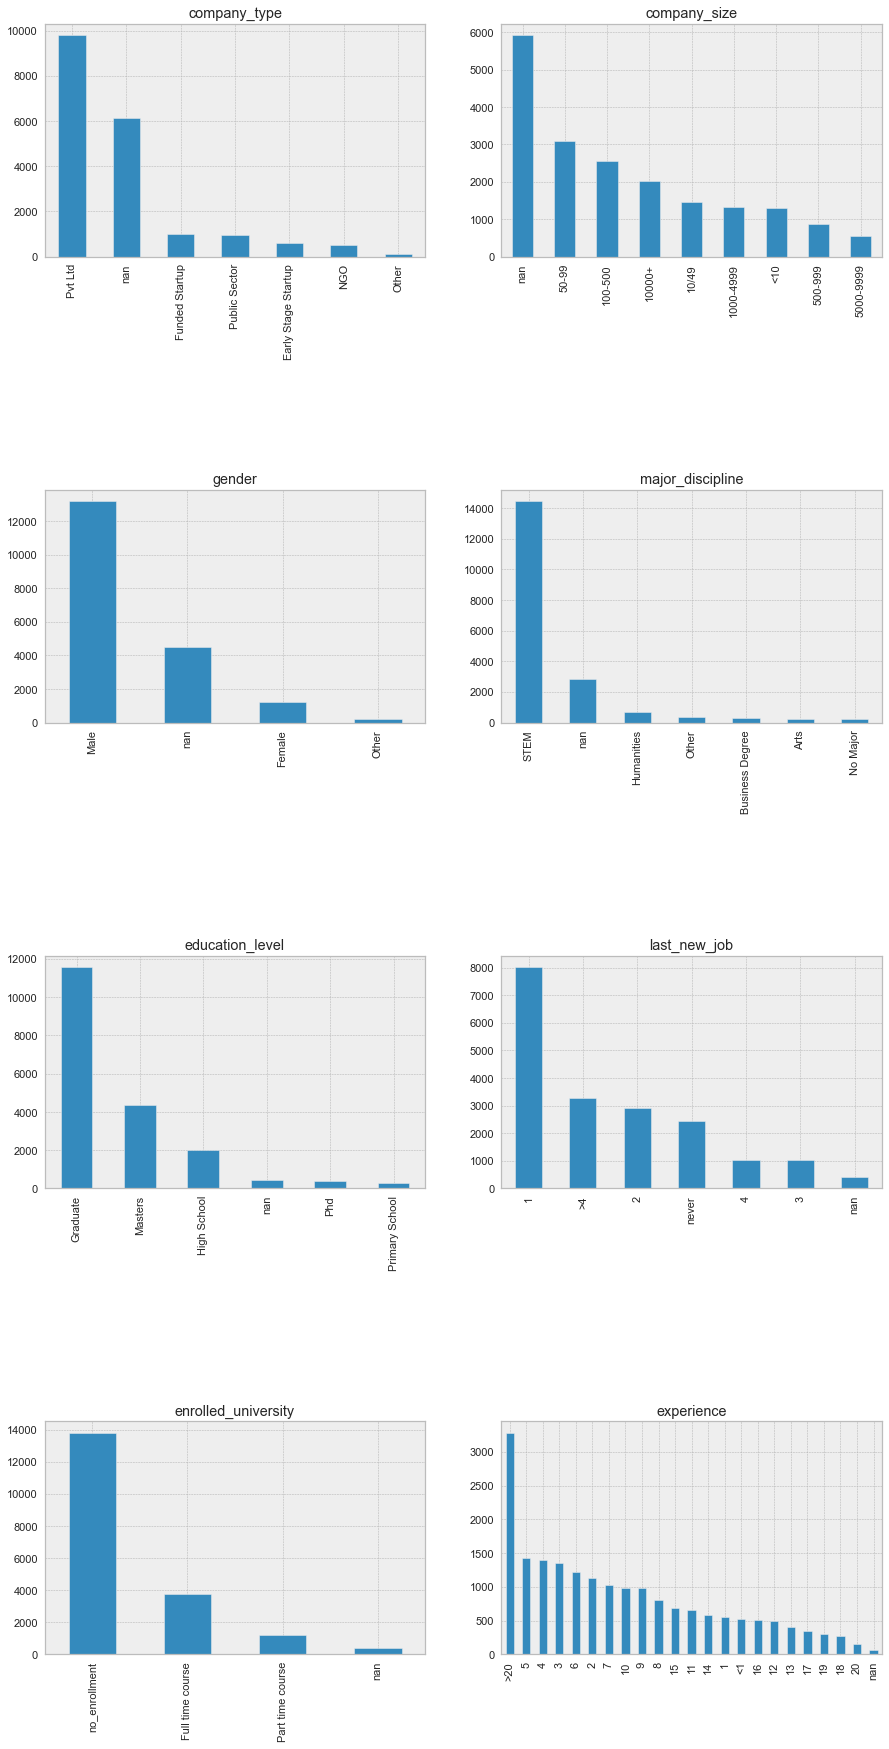

In [673]:
fig, axes = plt.subplots(nrows=4, ncols=2,figsize=(15,30))
plt.subplots_adjust(hspace=1) #subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)

# using value_counts(dropna=False) to show missing values
nan_cols

df1['company_type'].value_counts(dropna=False).plot(kind="bar", title='company_type', ax=axes[0,0]);
df1['company_size'].value_counts(dropna=False).plot(kind="bar", title='company_size', ax=axes[0,1]);
df1['gender'].value_counts(dropna=False).plot(kind="bar", title='gender', ax=axes[1,0]);
df1['major_discipline'].value_counts(dropna=False).plot(kind="bar", title='major_discipline', ax=axes[1,1]);
df1['education_level'].value_counts(dropna=False).plot(kind="bar", title='education_level', ax=axes[2,0]);
df1['last_new_job'].value_counts(dropna=False).plot(kind="bar", title='last_new_job', ax=axes[2,1]);
df1['enrolled_university'].value_counts(dropna=False).plot(kind="bar", title='enrolled_university', ax=axes[3,0]);
df1['experience'].value_counts(dropna=False).plot(kind="bar", title='experience', ax=axes[3,1]);


## 3.4 Fillout Missing Values

### Neste 1o ciclo, as variáveis com alto percentual de valores faltantes serão classificadas como "Unknown". Para as outras variávies iremos usar a moda ou seja, o valor com maior frequência.

In [674]:
# company_type
df1['company_type'].fillna('Unknown', inplace = True)

# company_size
df1['company_size'].fillna('Unknown', inplace = True)

# gender, replace the missing value by the most frequent value
df1['gender'].fillna(df1['gender'].mode()[0], inplace = True)

# major_discipline, replace the missing value by the most frequent value
df1['major_discipline'].fillna(df1['major_discipline'].mode()[0], inplace = True)

# education_level, replace the missing value by the most frequent value
df1['education_level'].fillna(df1['education_level'].mode()[0], inplace = True)

# last_new_job, replace the missing value by the most frequent value
df1['last_new_job'].fillna(df1['last_new_job'].mode()[0], inplace = True)

# enrolled_university, replace the missing value by the most frequent value
df1['enrolled_university'].fillna(df1['enrolled_university'].mode()[0], inplace = True)

# experience, replace the missing value by the most frequent value
df1['experience'].fillna(df1['experience'].mode()[0], inplace = True)

In [675]:
check_nan(df1)

● Dataset does not contains NaN values. No NaN found.


[]

# 4.0 FEATURE ENGINEERING

In [676]:
df2 = df1.copy()

## 4.1 Mapa Mental de Hipóteses

![feature_engineering](img/mind_map.png)

## 4.2 - Criando hipóteses para geração de insights

Brain storm de hipóteses, neste momento não levamos em consideração quais dados temos disponíveis e sim exploração de idéias.

**1.** Candidatos de cidades desenvolvidas mudam mais de emprego ?

**2.** Empresas localizadas no centro possuem mais influência na mudança de emprego ?

**3.** O Home-office é um fator forte para mudança de emprego ?

**4.** Candidatos com nível de escolaridade mais alto mudam mais de emprego ?

**5.** Candidatos com mais tempo de estudo mudam mais de emprego ?

**6.** Candidatos de empresas pequenas mudam mais de emprego ?

**7.** O final do ano é um indicador de maior mudança de emprego ?

**7.** Candidatos com mais experiências mudam mais de emprego ?

**9.** Candidatos com filhos mudam menos de emprego ?

**10.** Candidatos do sexo masculino mudam mais de emprego ?

**11.** Candidatos da área de exatas mudam mais de emprego ?

### 4.2.4 - Lista final de hipóteses.

Para a lista final, levaremos somente as hipóteses que poderão ser validadas com a base de dados em questão.

**1.** Candidatos de cidades desenvolvidas mudam mais de emprego ?

**2.** Candidatos com nível de escolaridade mais alto mudam mais de emprego ?

**3.** Candidatos com mais tempo de estudo mudam mais de emprego ?

**4.** Candidatos de empresas pequenas mudam mais de emprego ?

**5.** Candidatos com mais experiências mudam mais de emprego ?

**6.** Candidatos do sexo masculino mudam mais de emprego ?

**7.** Candidatos da área de exatas mudam mais de emprego ?

## 4.3 Variáveis Categóricas e Numéricas

In [677]:
# create dataframe by data type
num_attributes = df2.select_dtypes( exclude=['object', 'datetime64[ns]', 'category'] )
cat_attributes = df2.select_dtypes( include=['object', 'category'] )

print( '== Nossas variáveis numéricas ==========================================\n\n{}\n\n'.format(num_attributes.columns) )
print( '== Nossas variáveis categóricas ==========================================\n\n{}\n'.format(cat_attributes.columns) )

== Nossas variáveis numéricas ==========================================

Index(['enrollee_id', 'city_development_index', 'training_hours', 'target'], dtype='object')


== Nossas variáveis categóricas ==========================================

Index(['city', 'gender', 'relevent_experience', 'enrolled_university',
       'education_level', 'major_discipline', 'experience', 'company_size',
       'company_type', 'last_new_job'],
      dtype='object')



## 4.3 Feature Engineering - Variáveis Numéricas

Criação de faixas de valores baseado na disribuição dos quartis.

In [678]:
#cria classes , baseado nos quartis
df2['fe_cdi'] = df2['city_development_index'].apply( lambda x: 1 if x<=0.740000 else 2 if x<=0.903000 else 3 if x<=0.920000 else 4)
df2['fe_training_hours'] = df2['training_hours'].apply( lambda x: 1 if x<=23.000000 else 2 if x<=47.000000 else 3 if x<=88.000000 else 4)

df2[['city_development_index', 'fe_cdi', 'training_hours', 'fe_training_hours']].head()

,city_development_index,fe_cdi,training_hours,fe_training_hours
0,0.920,3,36,2
1,0.776,2,47,2
2,0.624,1,83,3
3,0.789,2,52,3
4,0.767,2,8,1


## 4.4 Feature Engineering - Variáveis Categóricas

Verificação da distribiuição das vafriáveis categóricas.

In [679]:
print('\n● Distribuição de categorias nas variáveis preditoras. \n')
for col in cat_attributes:
    svalues = df2[col].value_counts()
    print( '\n● {}\n'.format(col) )
    icont = 0
    for i, sval in enumerate(svalues): 
        print('● {} Qtde: {} Perc.: {}'.format( svalues.index[i], sval, sval / svalues.sum() ) )
        icont +=1
    print( '\nA variável {} possue {} categorias\n'.format(col, icont) )


● Distribuição de categorias nas variáveis preditoras. 


● city

● city_103 Qtde: 4355 Perc.: 0.22732017955945297
● city_21 Qtde: 2702 Perc.: 0.14103768660611754
● city_16 Qtde: 1533 Perc.: 0.08001879110554337
● city_114 Qtde: 1336 Perc.: 0.06973588057208477
● city_160 Qtde: 845 Perc.: 0.04410690051153565
● city_136 Qtde: 586 Perc.: 0.030587744023384485
● city_67 Qtde: 431 Perc.: 0.022497129136653096
● city_75 Qtde: 305 Perc.: 0.015920242196471448
● city_102 Qtde: 304 Perc.: 0.015868044681073182
● city_104 Qtde: 301 Perc.: 0.01571145213487838
● city_73 Qtde: 280 Perc.: 0.014615304311514771
● city_100 Qtde: 275 Perc.: 0.014354316734523438
● city_71 Qtde: 266 Perc.: 0.013884539095939034
● city_11 Qtde: 247 Perc.: 0.01289278630337196
● city_61 Qtde: 197 Perc.: 0.010282910533458608
● city_90 Qtde: 197 Perc.: 0.010282910533458608
● city_28 Qtde: 192 Perc.: 0.010021922956467273
● city_23 Qtde: 182 Perc.: 0.009499947802484601
● city_65 Qtde: 175 Perc.: 0.009134565194696732
● city_36 Qtde: 1

### ● Temos variáveis com alta cardinalidade ou seja, muitas categorias.

### ● Trabalharemos as variáveis categóricas com a técnica de Optimal Binning. Isso vai garantir um melhor information value.

In [680]:
df2['fe_enrolled_university'] = np.where( df2['enrolled_university'] ==  'no_enrollment', 0, 1)
df2['fe_education_level']     = df2['education_level'].apply( lambda x: 1 if x in ('High School', 'Primary School') else 2 if x == 'Graduate' else 3 )
df2['fe_major_discipline']    = np.where( df2['major_discipline'] == 'STEM', 'STEM', 'Other')
df2['fe_experience']          = df2['experience'].apply( lambda x: 1 if x in ('<', '1', '2' '3', '4', '5') else 2 if x in ('6', '7', '8', '9', '10') else 3 if x in ('11', '12', '13', '14', '15', '16', '17', '18', '19') else 4 )
df2['fe_company_size']        = df2['company_size'].apply( lambda x: 1 if x in ('<10', '10-49', '50-99') else 2 if x in ('100-500', '500-999') else 3 )
df2['fe_company_type']        = df2['company_type'].apply( lambda x: x if x in ('Pvt Ltd', 'Unknown') else 'Other' )
df2['fe_last_new_job']        = df2['last_new_job'].apply( lambda x: 0 if x == 'never' else 1 if x == '1' else 2 if x in ('2', '3') else 3  )
df2.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target,fe_cdi,fe_training_hours,fe_enrolled_university,fe_education_level,fe_major_discipline,fe_experience,fe_company_size,fe_company_type,fe_last_new_job
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,Unknown,Unknown,1,36,1.0,3,2,0,2,STEM,4,3,Unknown,1
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0,2,2,0,2,STEM,3,1,Pvt Ltd,3
2,11561,city_21,0.624,Male,No relevent experience,Full time course,Graduate,STEM,5,Unknown,Unknown,never,83,0.0,1,3,1,2,STEM,1,3,Unknown,0
3,33241,city_115,0.789,Male,No relevent experience,no_enrollment,Graduate,Business Degree,<1,Unknown,Pvt Ltd,never,52,1.0,2,3,0,2,Other,4,3,Pvt Ltd,0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0,2,1,0,3,STEM,4,1,Other,3


# 5.0 EXPLORATORY DATA ANALYSIS

## 5.1 Numerical Attributes Statistics

In [681]:
df2.describe()

,enrollee_id,city_development_index,training_hours,target,fe_cdi,fe_training_hours,fe_enrolled_university,fe_education_level,fe_experience,fe_company_size,fe_last_new_job
count,19158.000000,19158.000000,19158.000000,19158.000000,19158.000000,19158.000000,19158.000000,19158.000000,19158.000000,19158.000000,19158.000000
mean,16875.358179,0.828848,65.366896,0.249348,2.378954,2.489978,0.258639,2.127884,2.724763,2.361624,1.527717
std,9616.292592,0.123362,60.058462,0.432647,1.002653,1.123839,0.437898,0.595203,1.109679,0.830233,0.977824
min,1.000000,0.448000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,8554.250000,0.740000,23.000000,0.000000,1.000000,1.000000,0.000000,2.000000,2.000000,2.000000,1.000000
50%,16982.500000,0.903000,47.000000,0.000000,2.000000,2.000000,0.000000,2.000000,3.000000,3.000000,1.000000
75%,25169.750000,0.920000,88.000000,0.000000,3.000000,3.000000,1.000000,2.000000,4.000000,3.000000,2.000000
max,33380.000000,0.949000,336.000000,1.000000,4.000000,4.000000,1.000000,3.000000,4.000000,3.000000,3.000000


### ● A Média da variável target informa que 25% dos candidatos ( percentual de ocorrência do evento) mudaram de emprego.

## 5.2 Univariate Analysis

**Histograma**

**Definição:** uma uma representação gráfica em formato de retângulos cuja área é proporcional à frequência de uma variável quantitativa e cuja largura é igual ao intervalo de classe.

**Para que serve:** Um histograma é uma representação gráfica da distribuição de uma variável quantitativa contínua. Com o histograma pode-se visualizar a dispersão/concentração dos dados, bem como a assimetria/simetria dos dados. É muito utilizado para visualizar toda a distribuição de uma variável quantitativa. Foi introduzida pela primeira vez por Karl Pearson (OBS - É muito parecido com o gráfico de barras).

### 5.2.1 - Variáveis Numéricas

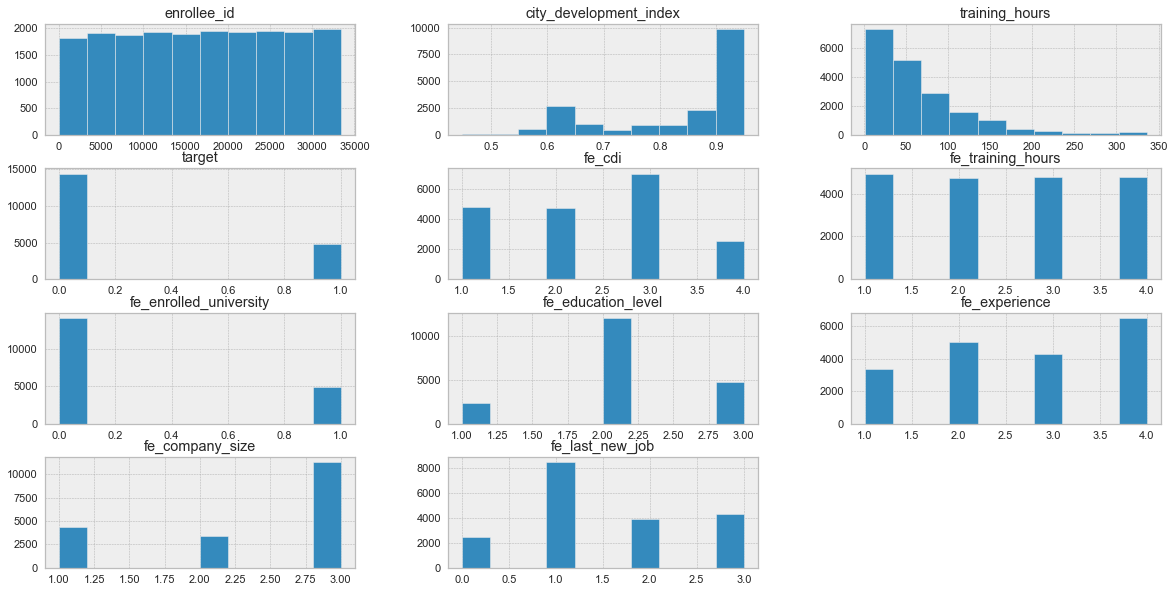

In [682]:
num_attributes = df2.select_dtypes( exclude=['object', 'datetime64[ns]', 'category'] )
num_attributes.hist();

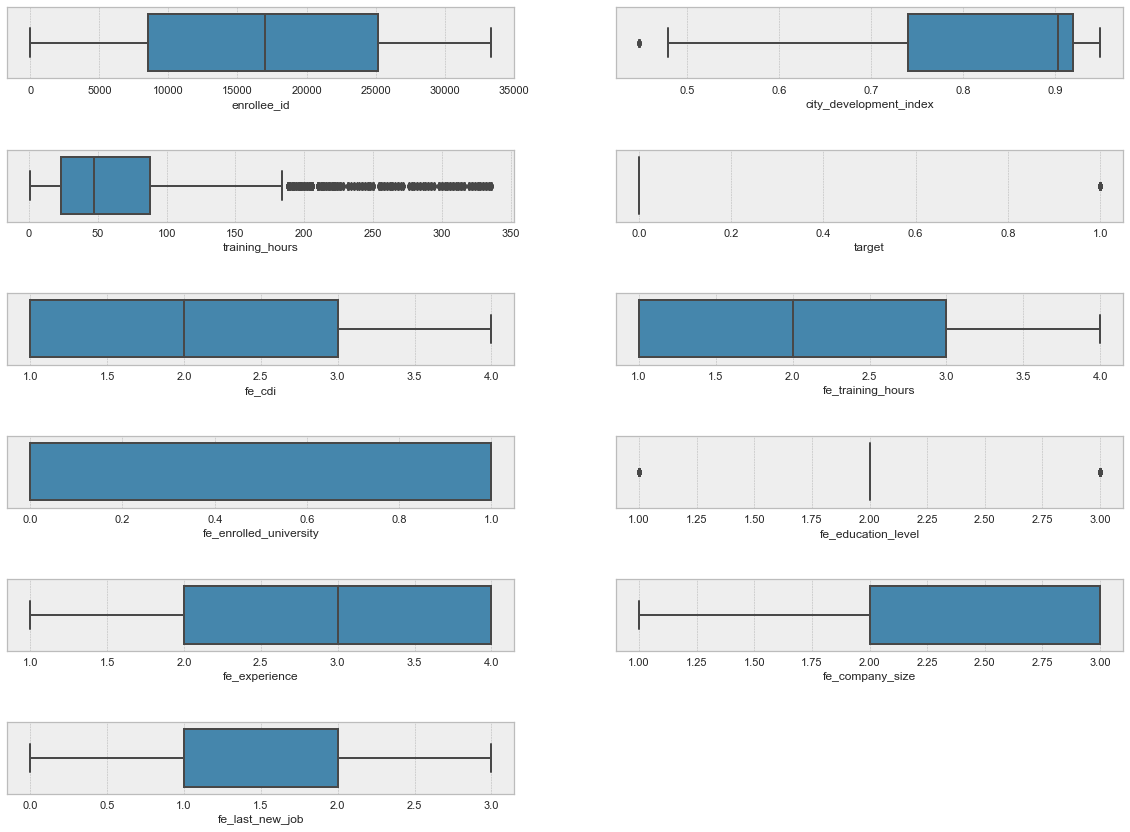

In [683]:
# mount grid 2 rows x 6 cols to receive charts
grid = GridSpec( nrows=10, ncols=2, hspace=1)
plt.figure(figsize=(20,25))

i = 0
iline = 1
ax_col = 1
ax_row = 0
for col in num_attributes.columns:
    #print(col)
    ax_col = int(not ax_col) # troca entre 0 e 1
    plt.subplot(grid[iline,ax_col])
    sns.boxplot( x=df2[col])
    if (i % 2 > 0):
        iline +=1
    i += 1

### ●  Nossas variáveis não possuem uma distribuição normal.

### ●  Temos outliers nas variáveis preditoras city_development_index e training_hours.

### 5.2.2 - Variáveis Categóricas

#### ● Nosso Dataset possui muitas variáveis categóricas (Nominais, Ordinais, Binárias), algumas com alta cardinalidade.

In [684]:
cat_attributes = df2.select_dtypes( include=['object', 'category'] )

print('● Variáveis categóricas e quantidades de categorias.\n')
for col in cat_attributes:
    print('● {}: {}'.format(col, len( df2[col].unique() ) ) )

● Variáveis categóricas e quantidades de categorias.

● city: 123
● gender: 3
● relevent_experience: 2
● enrolled_university: 3
● education_level: 5
● major_discipline: 6
● experience: 22
● company_size: 9
● company_type: 7
● last_new_job: 6
● fe_major_discipline: 2
● fe_company_type: 3


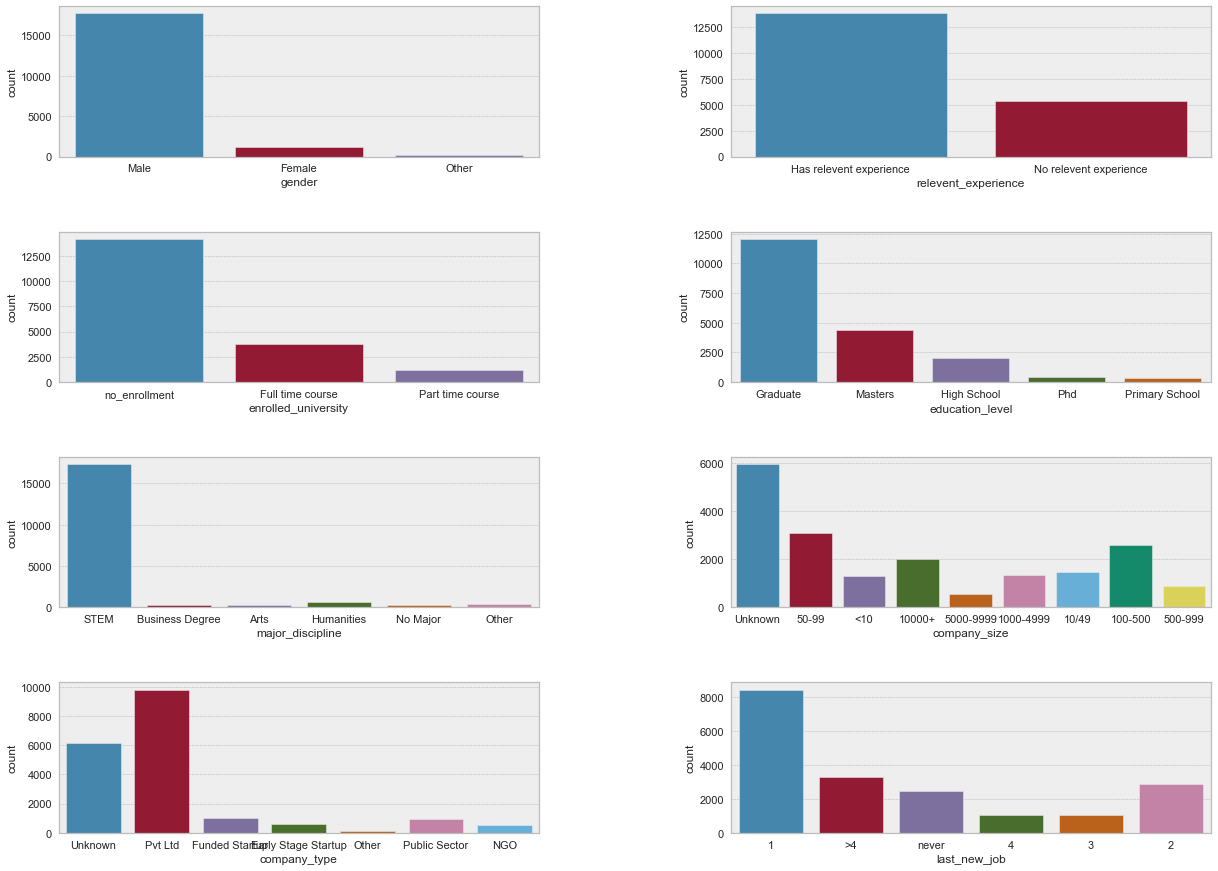

In [685]:
cat_list = ['gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'company_size', 'company_type', 'last_new_job']
plt.figure(figsize=(20,30))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.5)
i = 0
ilines_plot = 8
for col in cat_list:
    i += 1
    plt.subplot(ilines_plot, 2, i)
    #i += 1
    sns.countplot(df2[col])
    #plt.subplot(ilines_plot, 2, i)
    #for categ in df1[col].unique():
    #    sns.kdeplot(df1[df1[col] == categ]['target'], label=categ, shade=True) 
    #plt.legend()

### ● A Maioria dos candidatos são so sexo masculino.

### ● A Minoria dos candidatos possuem somente a educação escolar primária.

### ● A Maioria dos candidatos são da área de ciências exatas STEM (science, technology, engineering and mathematics).

### 5.2.2 Variável Resposta

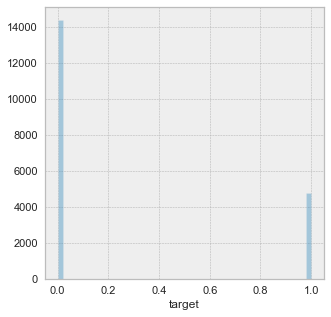

In [686]:
plt.rcParams['figure.figsize']=(5,5)
sns.distplot(df2['target'], kde=False);

#### ● Nossos dataset está desbalanceado. Temos mais candidatos que não mudaram de emprego. Isso pode enviesar o modelo, fazendo com que o mesmo não generalize.

#### ● Existem técnicas que tratam o desbalanceamentos dos dados, como o undersamplig e o oversampling.

## 5.3 Bivariate Analysis

In [687]:
df2.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target,fe_cdi,fe_training_hours,fe_enrolled_university,fe_education_level,fe_major_discipline,fe_experience,fe_company_size,fe_company_type,fe_last_new_job
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,Unknown,Unknown,1,36,1.0,3,2,0,2,STEM,4,3,Unknown,1
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0,2,2,0,2,STEM,3,1,Pvt Ltd,3
2,11561,city_21,0.624,Male,No relevent experience,Full time course,Graduate,STEM,5,Unknown,Unknown,never,83,0.0,1,3,1,2,STEM,1,3,Unknown,0
3,33241,city_115,0.789,Male,No relevent experience,no_enrollment,Graduate,Business Degree,<1,Unknown,Pvt Ltd,never,52,1.0,2,3,0,2,Other,4,3,Pvt Ltd,0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0,2,1,0,3,STEM,4,1,Other,3


### ● Confrontando variáveis preditoras com a variável resposta.

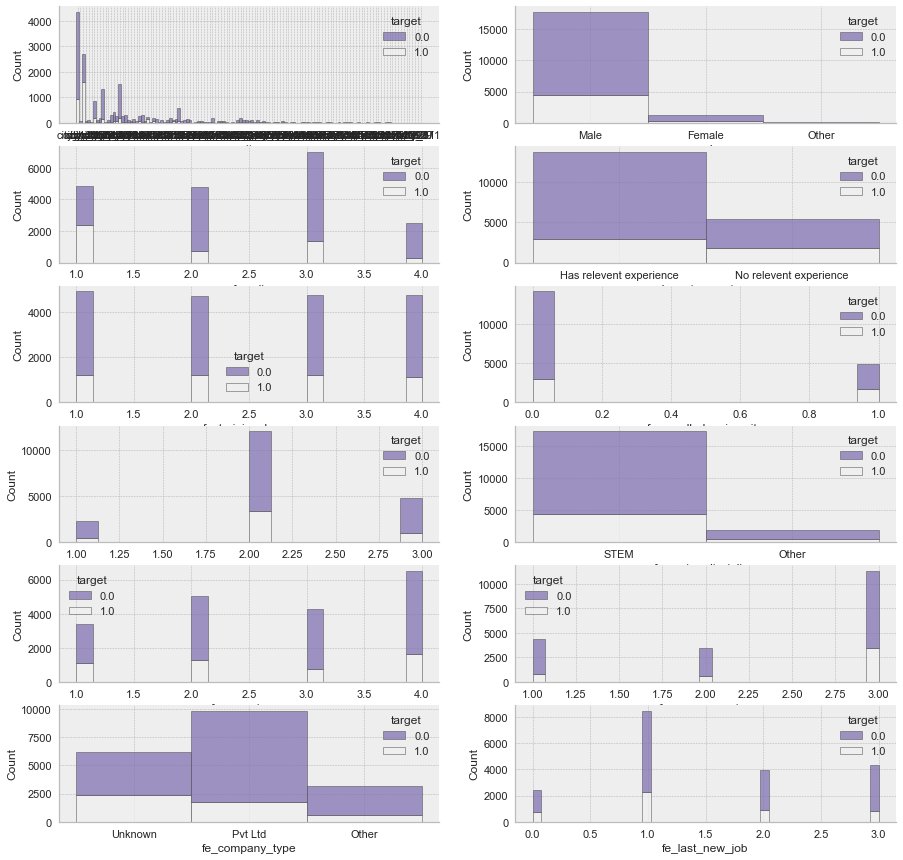

In [688]:
cat_list = ['city', 'gender', 'fe_cdi', 'relevent_experience', 'fe_training_hours', 'fe_enrolled_university', 'fe_education_level', 'fe_major_discipline', 'fe_experience', 'fe_company_size', 'fe_company_type', 'fe_last_new_job']

f, ax = plt.subplots( int( ceil( len(cat_list)/2 ) ), 2,figsize=(15, 15))

sns.despine(f)

i = 0
iline = 0
ax_col = 1
ax_row = 0
for col in cat_list:
    ax_col = int(not ax_col) # troca entre 0 e 1
    sns.histplot(
        df2,
        x=col,
        hue="target",
        multiple="stack",
        palette="light:m_r",
        edgecolor=".3",
        linewidth=.5,
        log_scale=False,
        ax=ax[iline,ax_col]
    );    
    if (i % 2 > 0):
        iline +=1
    i += 1

### 5.3.1 Validando Hipóteses

### H1. Candidatos de cidades desenvolvidas mudam mais de emprego ?

**Falso** Candidatos de cidades desenvolvidas mudam menos de emprego.

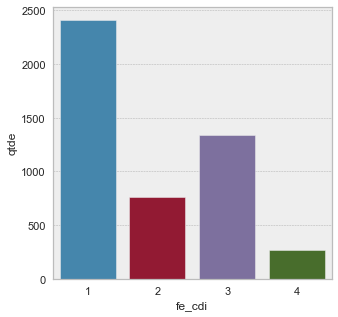

In [689]:
aux = df2.loc[df2['target'] == 1, 'fe_cdi'].reset_index().groupby('fe_cdi').size().to_frame('qtde').reset_index()
sns.barplot(x = 'fe_cdi', y = 'qtde', data = aux, ci = None);

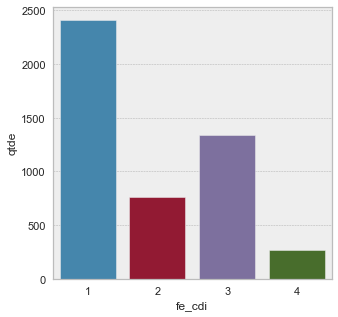

In [690]:
aux = df2.loc[df2['target'] == 1, 'fe_cdi'].reset_index().groupby('fe_cdi').size().to_frame('qtde').reset_index()
sns.barplot(x = 'fe_cdi', y = 'qtde', data = aux, ci = None);

### H2. Candidatos com nível de escolaridade mais alto mudam mais de emprego ?

**Falso** Candidatos com nível de escolaridade mais alto mudam menos de emprego.

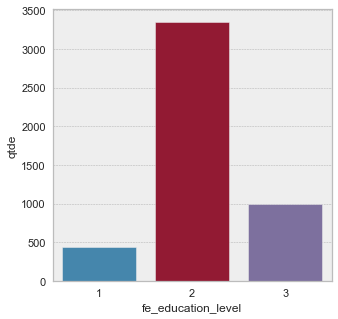

In [691]:
aux = df2.loc[df2['target'] == 1, 'fe_education_level'].reset_index().groupby('fe_education_level').size().to_frame('qtde').reset_index()
sns.barplot(x = 'fe_education_level', y = 'qtde', data = aux, ci = None);

### H3. Candidatos com mais tempo de estudo mudam mais de emprego ?

**Falso** Candidatos com mais tempo de estudo mudam menos de emprego.

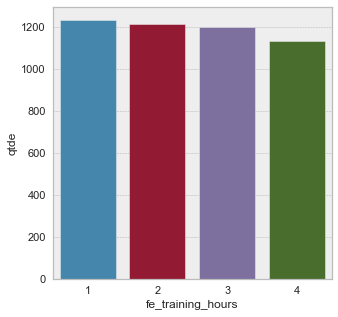

In [692]:
aux = df2.loc[df2['target'] == 1, 'fe_training_hours'].reset_index().groupby('fe_training_hours').size().to_frame('qtde').reset_index()
sns.barplot(x = 'fe_training_hours', y = 'qtde', data = aux, ci = None);

### H4. Candidatos de empresas pequenas mudam mais de emprego ?

**Falso** Candidatos de empresas maiores mudam mais de emprego.

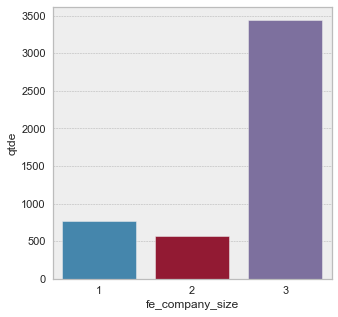

In [693]:
aux = df2.loc[df2['target'] == 1, 'fe_company_size'].reset_index().groupby('fe_company_size').size().to_frame('qtde').reset_index()
sns.barplot(x = 'fe_company_size', y = 'qtde', data = aux, ci = None);

### H5. Candidatos com mais experiências mudam mais de emprego ?

**Verdadeiro** Candidatos com mais experiências mudam mais de emprego.

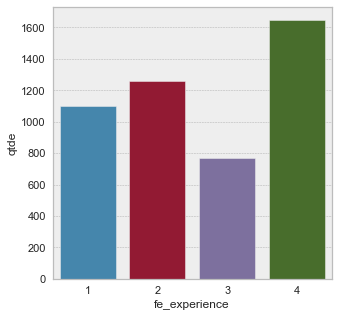

In [694]:
aux = df2.loc[df2['target'] == 1, 'fe_experience'].reset_index().groupby('fe_experience').size().to_frame('qtde').reset_index()
sns.barplot(x = 'fe_experience', y = 'qtde', data = aux, ci = None);

### H6. Candidatos do sexo masculino mudam mais de emprego ?

**Verdadeiro** Candidatos do sexo masculino mudam mais de emprego.

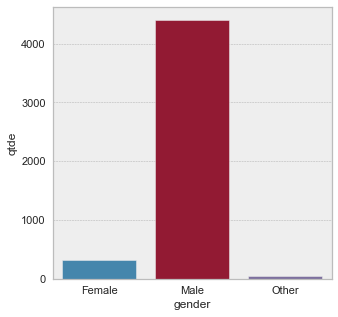

In [695]:
aux = df2.loc[df2['target'] == 1, 'gender'].reset_index().groupby('gender').size().to_frame('qtde').reset_index()
sns.barplot(x = 'gender', y = 'qtde', data = aux, ci = None);

### H7. Candidatos da área de exatas mudam mais de emprego ?

**Verdadeiro** Candidatos da área de exatas mudam mais de emprego.

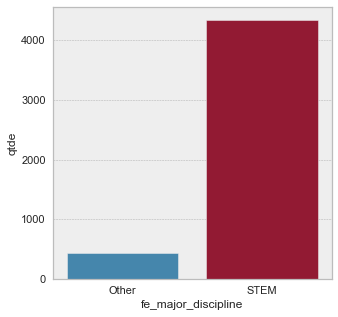

In [696]:
aux = df2.loc[df2['target'] == 1, 'fe_major_discipline'].reset_index().groupby('fe_major_discipline').size().to_frame('qtde').reset_index()
sns.barplot(x = 'fe_major_discipline', y = 'qtde', data = aux, ci = None);

### Resumo das Hipóteses

H1. **FALSO** Candidatos de cidades desenvolvidas mudam mais de emprego ?

H2. **FALSO** Candidatos com nível de escolaridade mais alto mudam mais de emprego ?

H3. **FALSO** Candidatos com mais tempo de estudo mudam mais de emprego ?

H4. **FALSO** Candidatos de empresas pequenas mudam mais de emprego ?

H5. **VERDADEIRO** Candidatos com mais experiências mudam mais de emprego ?

H6. **VERDADEIRO** Candidatos do sexo masculino mudam mais de emprego ?

H7. **VERDADEIRO** Candidatos da área de exatas mudam mais de emprego ?

## 5.5 Multivariate Analysis

### ● Utilizando o V de Cramer para análise de correlação entre variáveis categóricas.

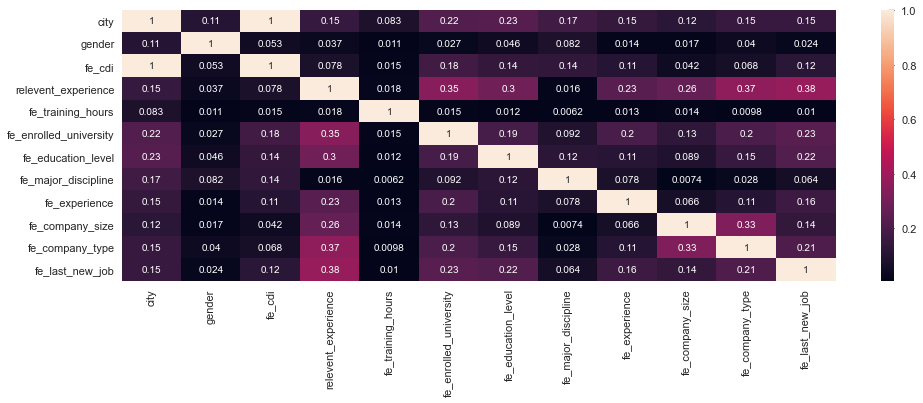

In [697]:
a = df2[cat_list]

i = 0
for v1 in a.columns:
    i +=1
    list_cramerv = []
    for v2 in a.columns:
        cramer_v_result = cramer_v(a[v1], a[v2])
        list_cramerv.append(cramer_v_result)
    df_cramerv_2 = pd.DataFrame({v1: list_cramerv})
    if i==1:
        df_cramerv = df_cramerv_2.copy()
    else:
        df_cramerv = pd.concat([df_cramerv, df_cramerv_2], axis=1)
        
df_cramerv = df_cramerv.set_index(df_cramerv.columns)
plt.figure(figsize = (16,5))
sns.heatmap(df_cramerv, annot=True);

### ● Identificamos um correlação forte entre as vaiáveis city e fe_cdi. Iremos descartar a variável city na execução do modelo.

# 6.0 DATA TRANSFORMATION



### Nesta sessão iremos transoformar os dados utilizando técnicas como One Hot Encoding, Label Encoding, Standartization, Scale, etc.

In [698]:
df3 = df2.copy()
df3.drop(['enrollee_id', 'city', 'city_development_index', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job', 'training_hours'], axis='columns', inplace=True)
df3.head()

,gender,relevent_experience,target,fe_cdi,fe_training_hours,fe_enrolled_university,fe_education_level,fe_major_discipline,fe_experience,fe_company_size,fe_company_type,fe_last_new_job
0,Male,Has relevent experience,1.0,3,2,0,2,STEM,4,3,Unknown,1
1,Male,No relevent experience,0.0,2,2,0,2,STEM,3,1,Pvt Ltd,3
2,Male,No relevent experience,0.0,1,3,1,2,STEM,1,3,Unknown,0
3,Male,No relevent experience,1.0,2,3,0,2,Other,4,3,Pvt Ltd,0
4,Male,Has relevent experience,0.0,2,1,0,3,STEM,4,1,Other,3


### ● Neste primeiro ciclo não faremos a normalização dos dados, até por que estão na mesma escala.

## 6.1 Transformation

### 6.1.1 Encoding

### ● Vamos transformar algumas varíaveis categóricas utilizando o one hot encoding.
### ● Antes do One Hot Encodig, vamos substituir o espaço entre as palavras pelo símbolo '_'.

In [699]:
cat_attributes = list(df3.select_dtypes(['object']).columns) #df3.select_dtypes( include=['object', 'category'] )

for col in cat_attributes:
    df3[col] = df3[col].apply(lambda x: x.replace(' ', '_').lower() )
df3.head()

,gender,relevent_experience,target,fe_cdi,fe_training_hours,fe_enrolled_university,fe_education_level,fe_major_discipline,fe_experience,fe_company_size,fe_company_type,fe_last_new_job
0,male,has_relevent_experience,1.0,3,2,0,2,stem,4,3,unknown,1
1,male,no_relevent_experience,0.0,2,2,0,2,stem,3,1,pvt_ltd,3
2,male,no_relevent_experience,0.0,1,3,1,2,stem,1,3,unknown,0
3,male,no_relevent_experience,1.0,2,3,0,2,other,4,3,pvt_ltd,0
4,male,has_relevent_experience,0.0,2,1,0,3,stem,4,1,other,3


### ● Aplica Onet Hot Encoding

In [700]:
df3 = pd.get_dummies(df3, columns=cat_attributes)
df3.head()

,target,fe_cdi,fe_training_hours,fe_enrolled_university,fe_education_level,fe_experience,fe_company_size,fe_last_new_job,gender_female,gender_male,gender_other,relevent_experience_has_relevent_experience,relevent_experience_no_relevent_experience,fe_major_discipline_other,fe_major_discipline_stem,fe_company_type_other,fe_company_type_pvt_ltd,fe_company_type_unknown
0,1.0,3,2,0,2,4,3,1,0,1,0,1,0,0,1,0,0,1
1,0.0,2,2,0,2,3,1,3,0,1,0,0,1,0,1,0,1,0
2,0.0,1,3,1,2,1,3,0,0,1,0,0,1,0,1,0,0,1
3,1.0,2,3,0,2,4,3,0,0,1,0,0,1,1,0,0,1,0
4,0.0,2,1,0,3,4,1,3,0,1,0,1,0,0,1,1,0,0


# 7.0 SPLIT DATAFRAME INTO TRAINING AND TEST

## 7.1 Split dataframe into predictors and target variable 

In [701]:
# create predicts variables
predictor_variables = df3.drop( ['target'], axis=1).columns.to_list()

X = df3[predictor_variables].values

# target variable
y = df3['target'].values # create list to target variable

## 7.2 Split dataframe into training and test

In [702]:
# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=100)

#build training test dataframe
X_df_train =pd.DataFrame( X_train, columns = predictor_variables )
X_df_test = pd.DataFrame( X_test,  columns = predictor_variables )
y_df_train =pd.DataFrame( y_train, columns = ['target'] )
y_df_test = pd.DataFrame( y_test,  columns = ['target'] )

In [703]:
print( '● Amostra de treino e teste possuem as mesmas características, conforme podemos ver na média de cada uma.\n\nMédia treino: {}\nMédia teste: {}'.format(np.mean(X_train), np.mean(X_test) ) )

● Amostra de treino e teste possuem as mesmas características, conforme podemos ver na média de cada uma.

Média treino: 1.0504179748370703
Média teste: 1.0540801915755864


# 8.0 FEATURE SELECTION

In [704]:
df3.head(2)

,target,fe_cdi,fe_training_hours,fe_enrolled_university,fe_education_level,fe_experience,fe_company_size,fe_last_new_job,gender_female,gender_male,gender_other,relevent_experience_has_relevent_experience,relevent_experience_no_relevent_experience,fe_major_discipline_other,fe_major_discipline_stem,fe_company_type_other,fe_company_type_pvt_ltd,fe_company_type_unknown
0,1.0,3,2,0,2,4,3,1,0,1,0,1,0,0,1,0,0,1
1,0.0,2,2,0,2,3,1,3,0,1,0,0,1,0,1,0,1,0


## 8.1 KS - Kolmogorov–Smirnov

● Utilizaremos o KS para identificar as variáveis significantes para o modelo.

In [705]:
lst_ks = []
for col in predictor_variables:
    #print(col)
    ks = ks_2samp( df3.loc[df3.target==0, col], df3.loc[df3.target==1, col] )
    dict_ks = {}
    dict_ks['variavel'] = col
    dict_ks['ks'] = ks[0]
    dict_ks['pvalue'] = ks[1]
    dict_ks['pvalue result'] = 'significativo' if ks[1] <=0.05 else 'não significativo'
    lst_ks.append(dict_ks)
    
df_ks = pd.DataFrame(lst_ks).sort_values("ks", ascending=False)
df_ks

,variavel,ks,pvalue,pvalue result
0,fe_cdi,0.335946,0.000000e+00,significativo
16,fe_company_type_unknown,0.237880,5.029332e-179,significativo
15,fe_company_type_pvt_ltd,0.187638,5.176390e-111,significativo
5,fe_company_size,0.172520,8.468763e-94,significativo
2,fe_enrolled_university,0.138734,1.134486e-60,significativo
10,relevent_experience_has_relevent_experience,0.133301,4.989163e-56,significativo
11,relevent_experience_no_relevent_experience,0.133301,4.989163e-56,significativo
6,fe_last_new_job,0.082650,9.310827e-22,significativo
4,fe_experience,0.075359,3.710037e-18,significativo
3,fe_education_level,0.055115,6.572223e-10,significativo


● O KS das variáveis está bem baixo, temos muita sobreposição entre as classes.

● Temos algumas variáveis não significativas pro modelo.

## 8.2 Drop non significants variables from model

In [706]:
df_ks.loc[(df_ks['pvalue']>=0.05)]

,variavel,ks,pvalue,pvalue result
1,fe_training_hours,0.016490,0.280603,não significativo
13,fe_major_discipline_stem,0.006983,0.994367,não significativo
12,fe_major_discipline_other,0.006983,0.994367,não significativo
8,gender_male,0.005489,0.999900,não significativo
7,gender_female,0.004827,0.999996,não significativo
9,gender_other,0.000662,1.000000,não significativo


In [707]:
X_df_train.drop(['fe_training_hours', 'fe_major_discipline_stem', 'fe_major_discipline_other', 'gender_male', 'gender_female', 'gender_other'], axis=1, inplace=True)
X_df_test.drop(['fe_training_hours', 'fe_major_discipline_stem', 'fe_major_discipline_other', 'gender_male', 'gender_female', 'gender_other'], axis=1, inplace=True)

# 9.0 BASELINE - Majority Learner/ZeroR

In [708]:
# Baseline classifier train class
counter = collections.Counter(y_train)
base_line= np.array( [ counter[0] / (counter[0] + counter[1]), counter[1] / (counter[0] + counter[1]) ] )
bl = base_line.max()

print('\n● Se tirarmos aleatoriamente uma linha do dataset, temos {:2.2f}% de probalididade de ser da classe 0, a classe majoritária.'.format(bl*100))


● Se tirarmos aleatoriamente uma linha do dataset, temos 75.25% de probalididade de ser da classe 0, a classe majoritária.


# 10.0 UNBALANCED DATASET MODEL

### Modelos desbalanceados vão ter problemas na hora de generalizar. O modelo ficará propenso a classificar a classe majoritária.

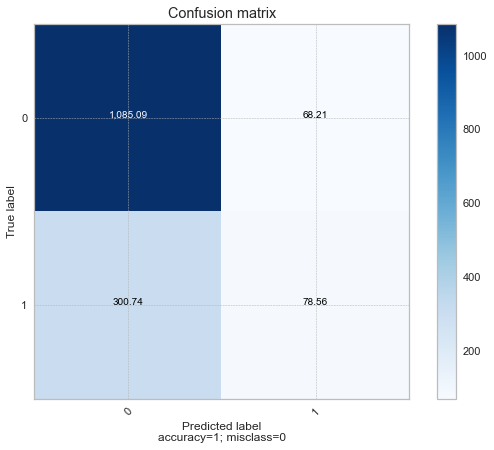

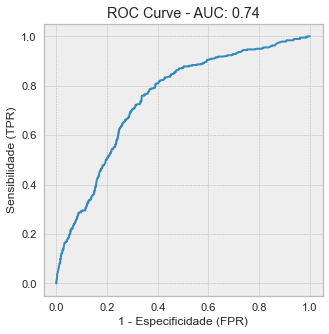

,Classifier Name,Tempo de execução (s):,Accuracy score,Precision score,Recall score,F1 score,Specificity,NPV,Balanced Accuracy score,AUC,Kappa score,Matthews Correlation Coefficient
0,LogisticRegression Classifier,8.417299,0.76,0.54,0.21,0.3,0.94,0.78,0.57,0.74,0.19,0.22


In [709]:
lr = LogisticRegression()
lr_result_cv = udf_cross_validation(X_df_train, y_df_train, 'LogisticRegression Classifier', lr, 10, 10, verbose=False)
lr_result_cv

● **Accuracy score:** 0.76.

● Quando temos um grande desequilíbrio de classes, essa medida - **Accuracy score** - não é muito adequada, pois o modelo, geralmente, fará previsões segundo a classe majoritária, obtendo bons resultados, mas não será útil no contexto do problema.

# 11.0 DATASET BALANCING

## 11.1 Dados Desbalanceados

Dados desbalanceados.

Class distribution
0.0    14381
1.0     4777
Name: target, dtype: int64


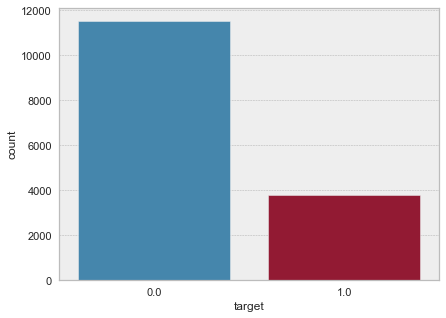

In [710]:
print('Dados desbalanceados.\n')
print('Class distribution\n{}'.format(df3['target'].value_counts()))
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(x='target', data=y_df_train);

## 11.2 Aplicando a técnica de Oversampling utilizando o algorítmo SMOTETomek.



Dados Balanceados após aplicação da técnica de Oversampling com a biblioteca SMOTETomek.


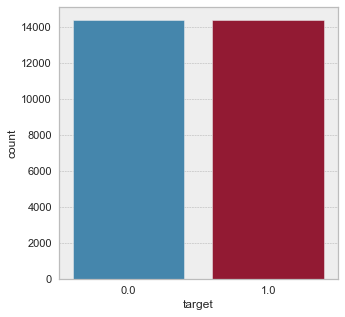

In [711]:
# ratio_balanced = (majority class / minority class) * minority class
balance = int( ( df3['target'].value_counts()[0]/df3['target'].value_counts()[1] ) * df3['target'].value_counts()[1] )
ratio_balanced = {0 : df3['target'].value_counts()[0], 1: balance}

#smt = SMOTE(sampling_strategy='auto')
smt = SMOTETomek(sampling_strategy=ratio_balanced, random_state=32, n_jobs=-1)
X_df_train_resampled, y_df_train_resampled = smt.fit_sample(X_df_train, y_df_train)

#plt.subplot(1,2,2)
print('\n\nDados Balanceados após aplicação da técnica de Oversampling com a biblioteca SMOTETomek.')
sns.countplot(x='target', data=y_df_train_resampled);

# 12.0 MACHINE LEARNING MODELLING - TRAINING DATASET

## 12.1 Confuson Matrix Concept


#### True Positive (TP): It refers to the number of predictions where the classifier correctly predicts the positive class as positive.

#### True Negative (TN): It refers to the number of predictions where the classifier correctly predicts the negative class as negative.

#### False Positive (FP): It refers to the number of predictions where the classifier incorrectly predicts the negative class as positive.

#### False Negative (FN): It refers to the number of predictions where the classifier incorrectly predicts the positive class as negative.

![confusion_matrix](img/matriz_confusao2.png)

## 12.2 Metrics Concepts


**Accuracy:** It gives you the overall accuracy of the model, meaning the fraction of the total samples that were correctly classified by the classifier. To calculate accuracy, use the following formula: **(TP+TN)/(TP+TN+FP+FN).**

**Misclassification Rate:** It tells you what fraction of predictions were incorrect. It is also known as Classification Error. You can calculate it using **(FP+FN)/(TP+TN+FP+FN) or (1-Accuracy).**

**Precision:** It tells you what fraction of predictions as a positive class were actually positive. To calculate precision, use the following formula: **TP/(TP+FP).**

**Recall:** True positive rate, sensitivity. It tells you what fraction of all positive samples were correctly predicted as positive by the classifier. It is also known as True Positive Rate (TPR), Sensitivity, Probability of Detection. To calculate Recall, use the following formula: **TP/(TP+FN).**]

**Specificity:** It tells you what fraction of all negative samples are correctly predicted as negative by the classifier. It is also known as True Negative Rate (TNR). To calculate specificity, use the following formula: **TN/(TN+FP).**

**F1-score:** It combines precision and recall into a single measure. Mathematically it’s the harmonic mean of precision and recall. It can be calculated as follows:


### Now, in a perfect world, we’d want a model that has a precision of 1 and a recall of 1. That means a F1-score of 1, i.e. a 100% accuracy which is often not the case for a machine learning model. So what we should try, is to get a higher precision with a higher recall value.

## 12.3 Naive Bayes Classifier  

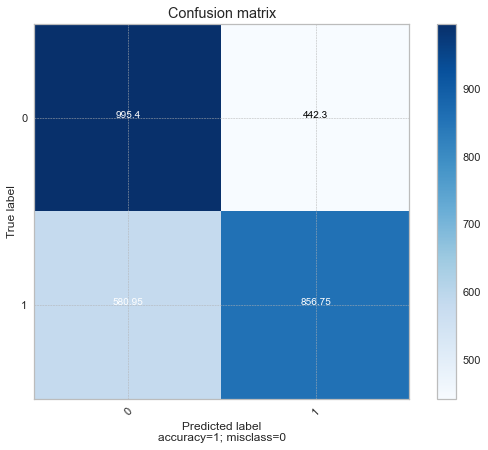

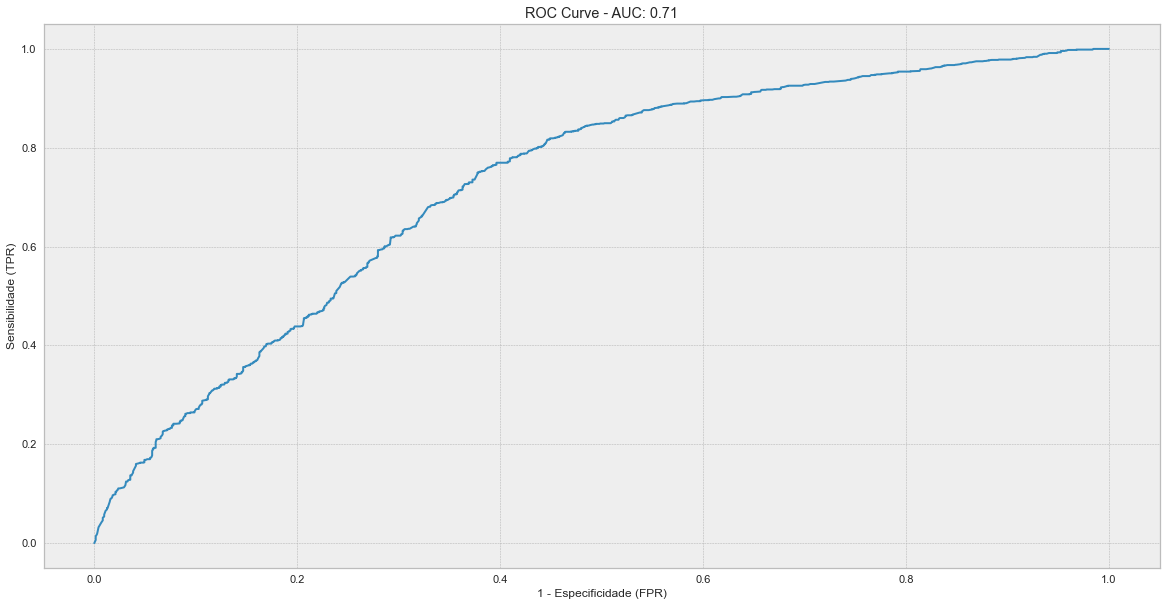

,Classifier Name,Tempo de execução (s):,Accuracy score,Precision score,Recall score,F1 score,Specificity,NPV,Balanced Accuracy score,AUC,Kappa score,Matthews Correlation Coefficient
0,Naive Bayes Classifier,4.539655,0.64,0.66,0.6,0.63,0.69,0.63,0.64,0.71,0.29,0.29


In [457]:
nb = GaussianNB()
nb_result_cv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled, 'Naive Bayes Classifier', nb, 10, 10, verbose=False)
nb_result_cv

## 12.4 Decision Tree Classifier  

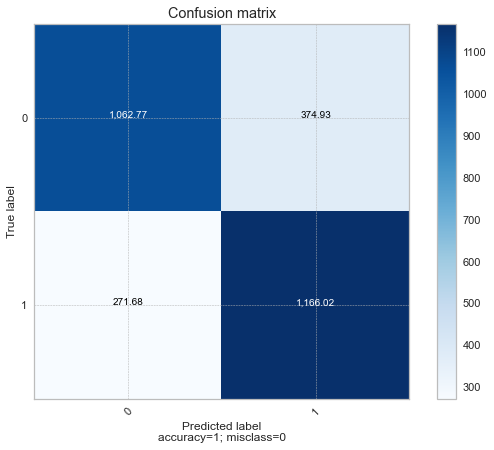

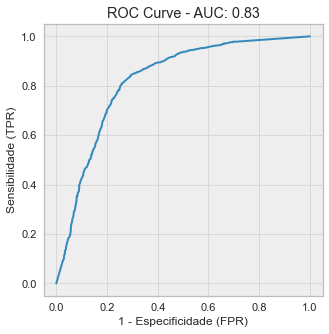

,Classifier Name,Tempo de execução (s):,Accuracy score,Precision score,Recall score,F1 score,Specificity,NPV,Balanced Accuracy score,AUC,Kappa score,Matthews Correlation Coefficient
0,DecisionTreeClassifier,5.842099,0.78,0.76,0.81,0.78,0.74,0.8,0.78,0.83,0.55,0.55


In [712]:
dtc = DecisionTreeClassifier()
dtc_result_cv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled, 'DecisionTreeClassifier', dtc, 10, 10, verbose=False)
dtc_result_cv

## 12.5 KNN Classifier  

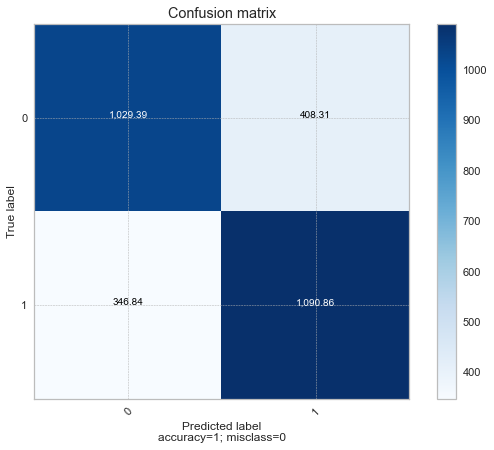

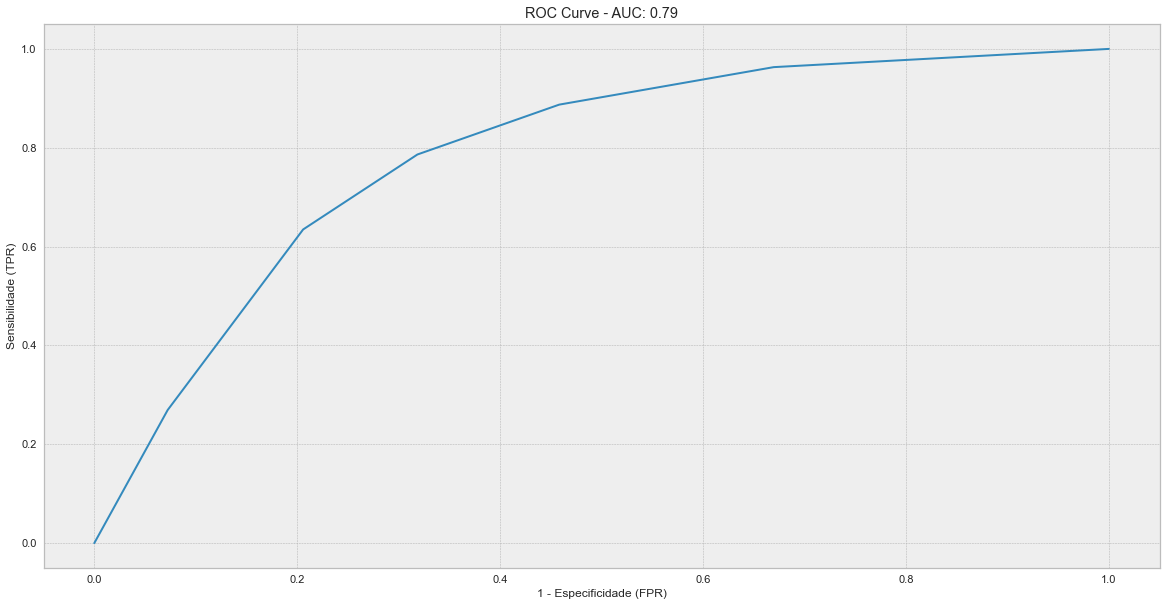

,Classifier Name,Tempo de execução (s):,Accuracy score,Precision score,Recall score,F1 score,Specificity,NPV,Balanced Accuracy score,AUC,Kappa score,Matthews Correlation Coefficient
0,KNN Classifier,71.859179,0.74,0.73,0.76,0.74,0.72,0.75,0.74,0.79,0.47,0.48


In [459]:
knn = KNeighborsClassifier()
knn_result_cv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled, 'KNN Classifier', knn, 10, 10, verbose=False)
knn_result_cv

## 12.6 LogisticRegression Classifier

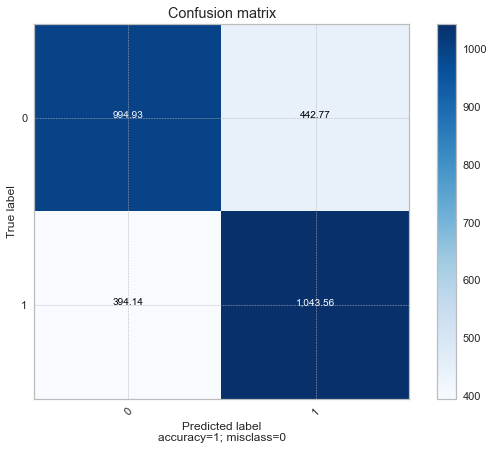

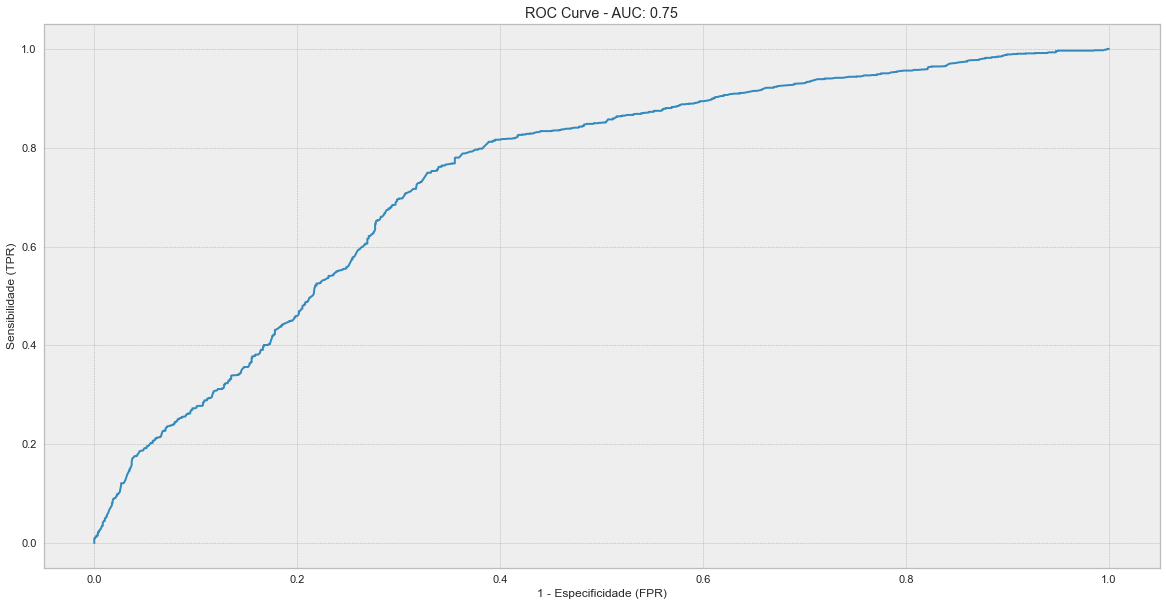

,Classifier Name,Tempo de execução (s):,Accuracy score,Precision score,Recall score,F1 score,Specificity,NPV,Balanced Accuracy score,AUC,Kappa score,Matthews Correlation Coefficient
0,LogisticRegression Classifier,17.477851,0.71,0.7,0.73,0.71,0.69,0.72,0.71,0.75,0.42,0.42


In [460]:
lr = LogisticRegression()
lr_result_cv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled, 'LogisticRegression Classifier', lr, 10, 10, verbose=False)
lr_result_cv

## 12.7 Support Vector Machine Classifier

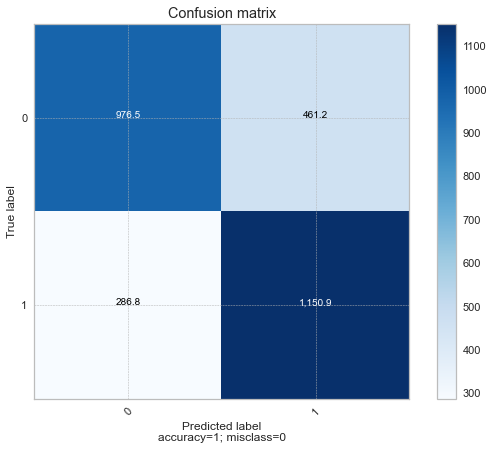

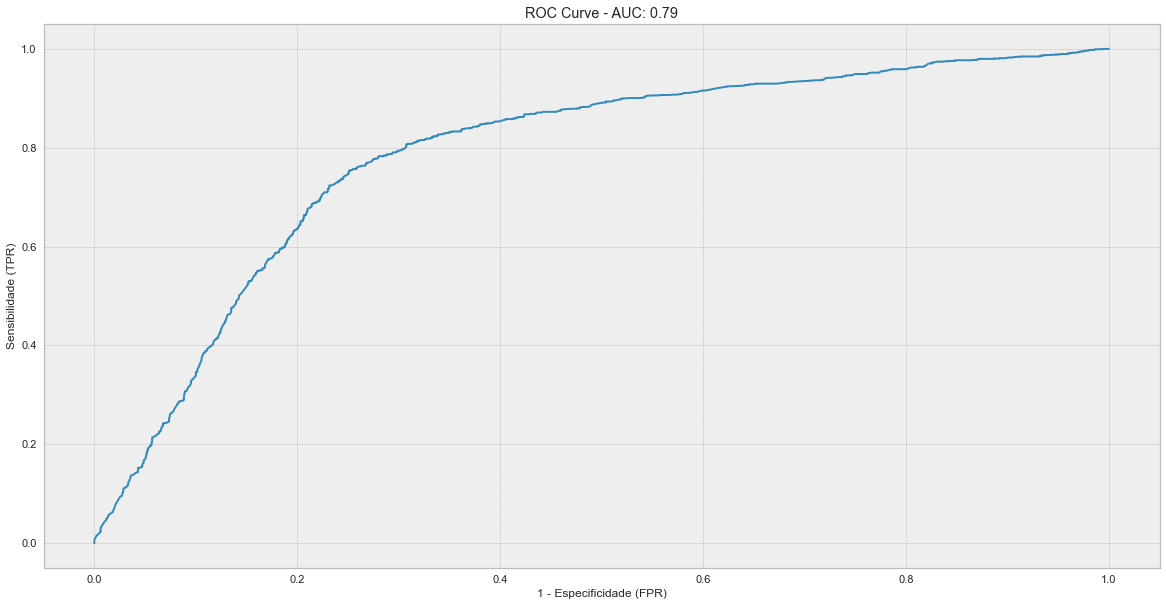

,Classifier Name,Tempo de execução (s):,Accuracy score,Precision score,Recall score,F1 score,Specificity,NPV,Balanced Accuracy score,AUC,Kappa score,Matthews Correlation Coefficient
0,SVM Classifier,1210.705527,0.74,0.71,0.8,0.75,0.68,0.77,0.74,0.79,0.48,0.48


In [461]:
svm = SVC( probability=True )
svm_result_cv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled, 'SVM Classifier', svm, 10, 1, verbose=False)
svm_result_cv

## 12.8 Neural Network Classifier

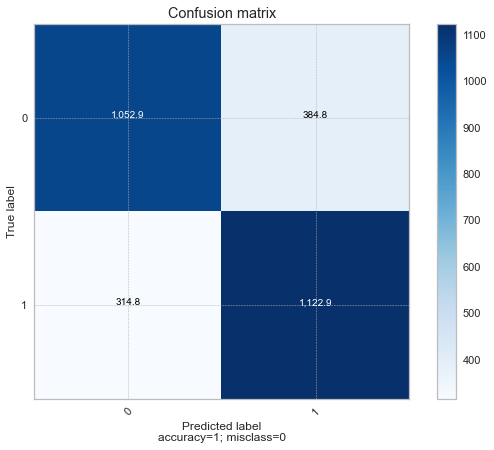

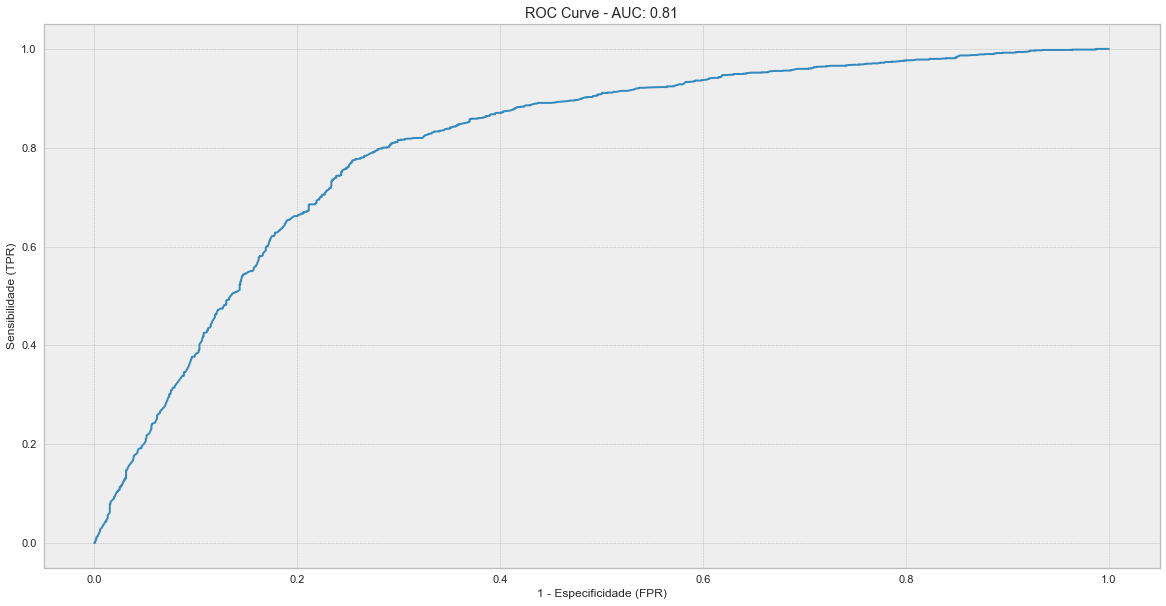

,Classifier Name,Tempo de execução (s):,Accuracy score,Precision score,Recall score,F1 score,Specificity,NPV,Balanced Accuracy score,AUC,Kappa score,Matthews Correlation Coefficient
0,NeuralNertwork Classifier,375.166587,0.76,0.74,0.78,0.76,0.73,0.77,0.76,0.81,0.51,0.51


In [462]:
mlp = MLPClassifier(verbose=False)
mlp_result_cv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled, 'NeuralNertwork Classifier', mlp, 10, 1, verbose=False)
mlp_result_cv

## 12.9 Random Forest Classifier

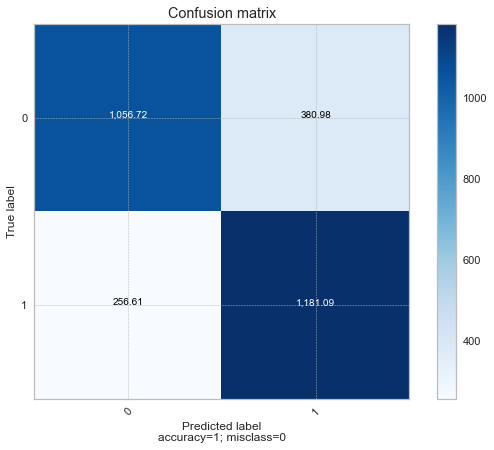

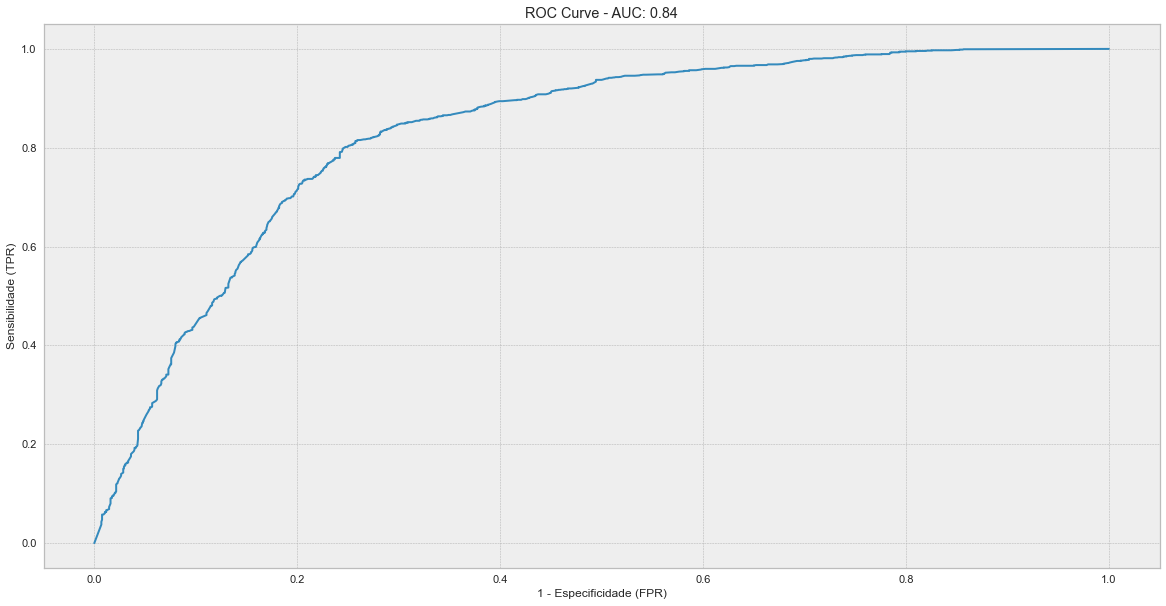

,Classifier Name,Tempo de execução (s):,Accuracy score,Precision score,Recall score,F1 score,Specificity,NPV,Balanced Accuracy score,AUC,Kappa score,Matthews Correlation Coefficient
0,Random Forest Classifier,148.259491,0.78,0.76,0.82,0.79,0.74,0.8,0.78,0.84,0.56,0.56


In [463]:
rf = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)
rf_result_cv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled, 'Random Forest Classifier', rf, 10, 10, verbose=False)
rf_result_cv

## 12.10 XGBoost Classifier

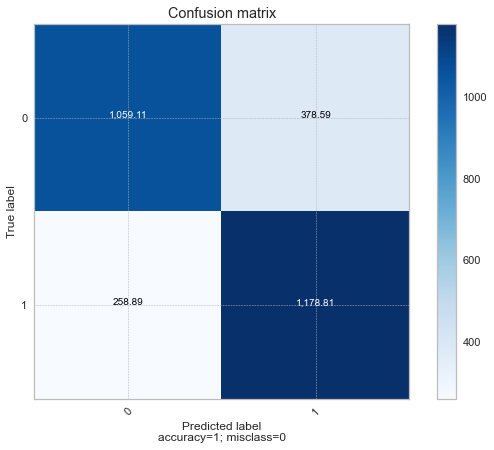

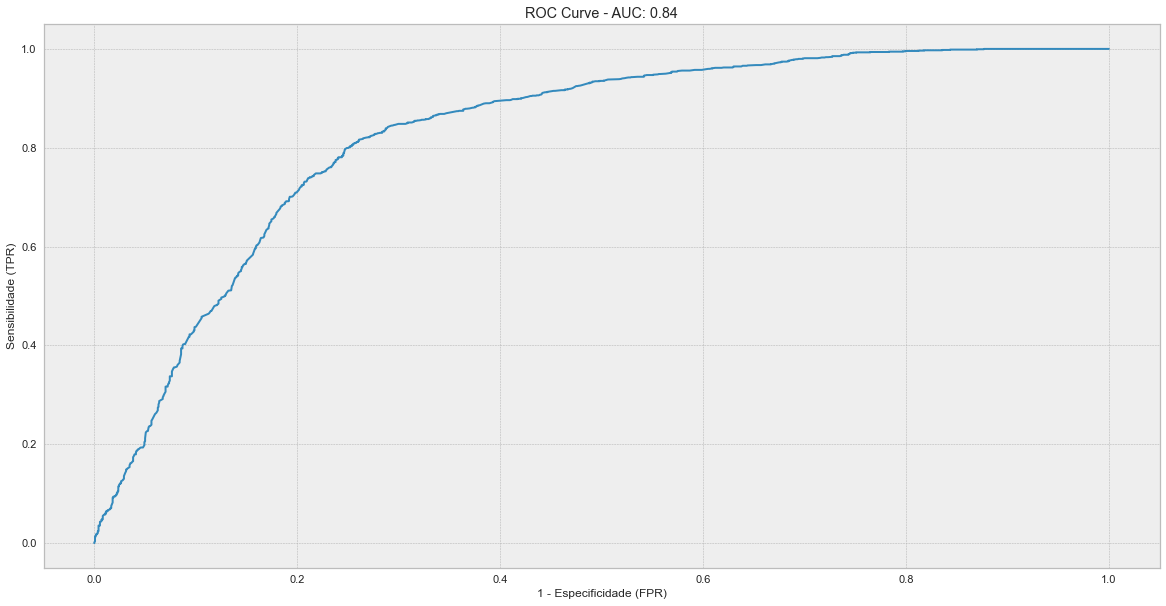

,Classifier Name,Tempo de execução (s):,Accuracy score,Precision score,Recall score,F1 score,Specificity,NPV,Balanced Accuracy score,AUC,Kappa score,Matthews Correlation Coefficient
0,XGBoost Classifier,593.445425,0.78,0.76,0.82,0.79,0.74,0.8,0.78,0.84,0.56,0.56


In [464]:
xgb_model = XGBClassifier(n_jobs=-1, subsample=1.0, n_estimators=210, min_samples_split=32, min_samples_leaf=22, max_features=13, max_depth=85, learning_rate=0.11800000000000001)
xgb_result_cv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled, 'XGBoost Classifier', xgb_model, 10, 10, verbose=False)
xgb_result_cv

## 12.11 XGBoostRF Classifier

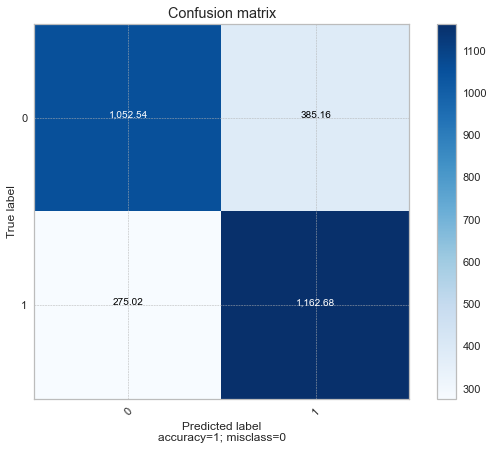

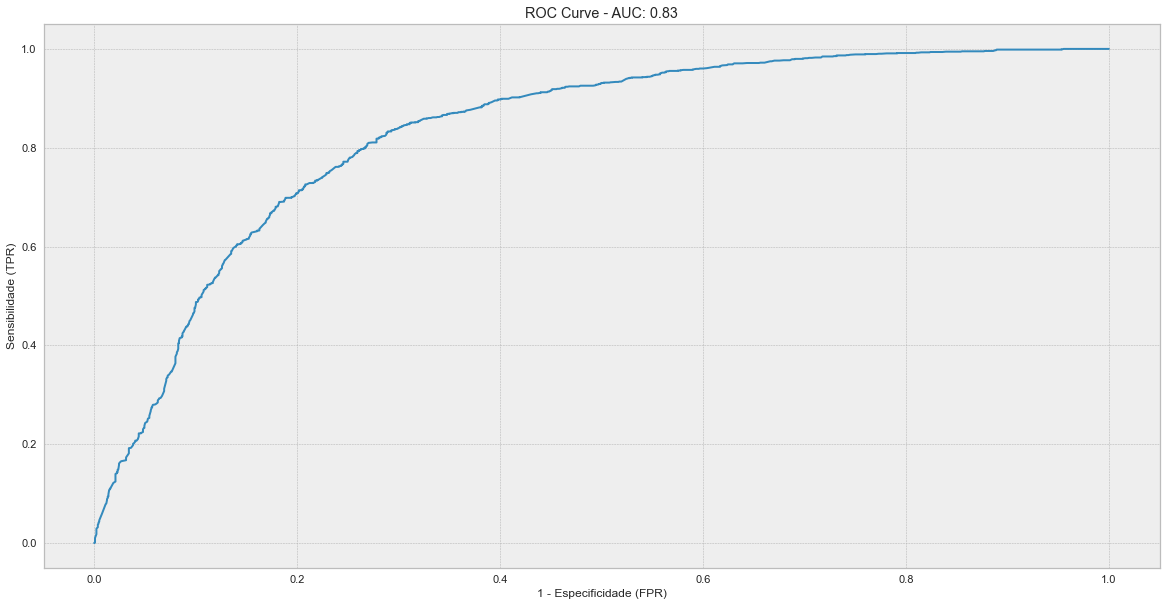

,Classifier Name,Tempo de execução (s):,Accuracy score,Precision score,Recall score,F1 score,Specificity,NPV,Balanced Accuracy score,AUC,Kappa score,Matthews Correlation Coefficient
0,XGBoostRF Classifier,216.096059,0.77,0.75,0.81,0.78,0.73,0.79,0.77,0.83,0.54,0.54


In [465]:
xgbrf_model = XGBRFClassifier(n_jobs=-1, subsample=1.0, n_estimators=210, min_samples_split=32, min_samples_leaf=22, max_features=13, max_depth=85, learning_rate=0.11800000000000001)
xgbrf_result_cv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled, 'XGBoostRF Classifier', xgbrf_model, 10, 5, verbose=False)
xgbrf_result_cv

## 12.12 Real Model´s Performance

In [466]:
model_result_cv = pd.concat([nb_result_cv, dtc_result_cv, knn_result_cv, lr_result_cv, svm_result_cv, mlp_result_cv, rf_result_cv, xgb_result_cv, xgbrf_result_cv]).reset_index()
model_result_cv.sort_values(by='Accuracy score',  ascending=False)

,index,Classifier Name,Tempo de execução (s):,Accuracy score,Precision score,Recall score,F1 score,Specificity,NPV,Balanced Accuracy score,AUC,Kappa score,Matthews Correlation Coefficient
1,0,DecisionTreeClassifier,6.031565,0.78,0.76,0.81,0.78,0.74,0.8,0.78,0.83,0.55,0.55
6,0,Random Forest Classifier,148.259491,0.78,0.76,0.82,0.79,0.74,0.8,0.78,0.84,0.56,0.56
7,0,XGBoost Classifier,593.445425,0.78,0.76,0.82,0.79,0.74,0.8,0.78,0.84,0.56,0.56
8,0,XGBoostRF Classifier,216.096059,0.77,0.75,0.81,0.78,0.73,0.79,0.77,0.83,0.54,0.54
5,0,NeuralNertwork Classifier,375.166587,0.76,0.74,0.78,0.76,0.73,0.77,0.76,0.81,0.51,0.51
2,0,KNN Classifier,71.859179,0.74,0.73,0.76,0.74,0.72,0.75,0.74,0.79,0.47,0.48
4,0,SVM Classifier,1210.705527,0.74,0.71,0.8,0.75,0.68,0.77,0.74,0.79,0.48,0.48
3,0,LogisticRegression Classifier,17.477851,0.71,0.7,0.73,0.71,0.69,0.72,0.71,0.75,0.42,0.42
0,0,Naive Bayes Classifier,4.539655,0.64,0.66,0.6,0.63,0.69,0.63,0.64,0.71,0.29,0.29


# 13.0 MODEL EVALUATION - TEST DATASET 

## 13.1 Naive Bayes Classifier

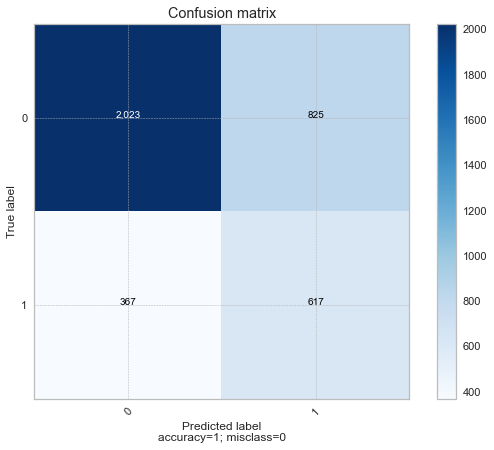

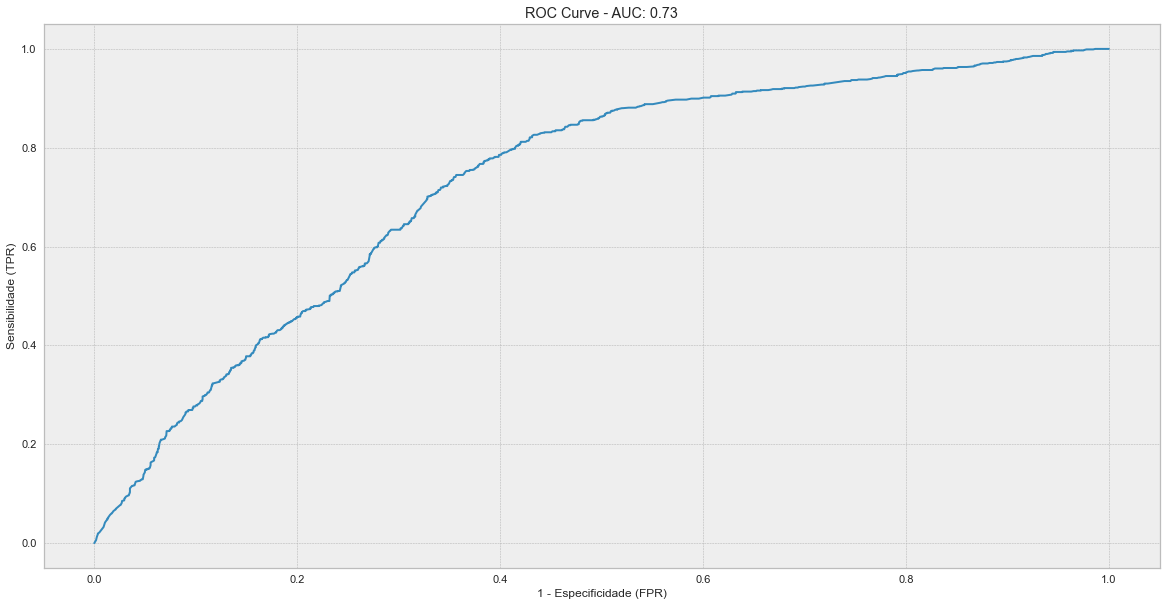

,Classifier Name,Tempo de execução (s):,Accuracy score,Precision score,Recall score,F1 score,Specificity,NPV,Balanced Accuracy score,AUC,Kappa score,Matthews Correlation Coefficient
0,Naive Bayes,0.468045,0.69,0.43,0.63,0.51,0.71,0.85,0.67,0.73,0.29,0.3


In [467]:
nb_result = test_dataset_metrics(X_df_test, y_test, nb, 'Naive Bayes')
nb_result

## 13.2 Decision Tree Classifier

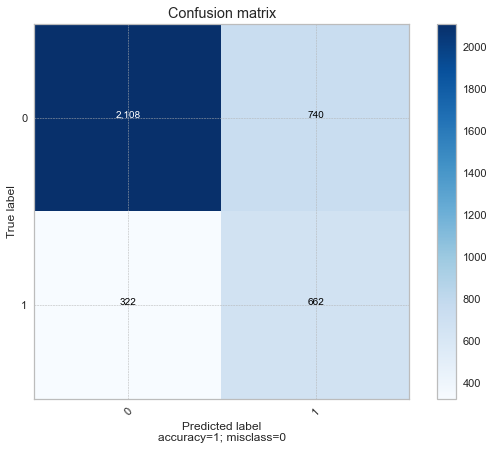

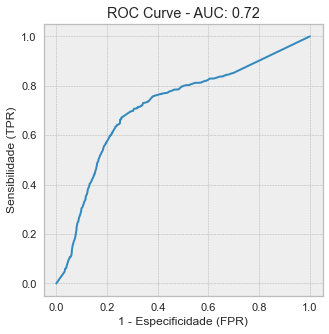

,Classifier Name,Tempo de execução (s):,Accuracy score,Precision score,Recall score,F1 score,Specificity,NPV,Balanced Accuracy score,AUC,Kappa score,Matthews Correlation Coefficient
0,Decision Tree,0.465583,0.72,0.47,0.67,0.55,0.74,0.87,0.71,0.72,0.36,0.37


In [807]:
dt_result = test_dataset_metrics(X_df_test, y_test, dtc, 'Decision Tree')
dt_result

## 13.3 KNN Classifier

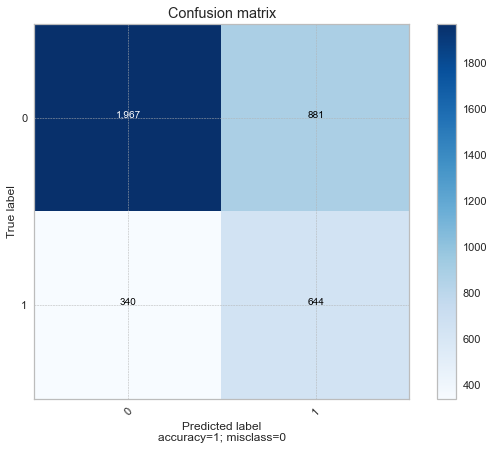

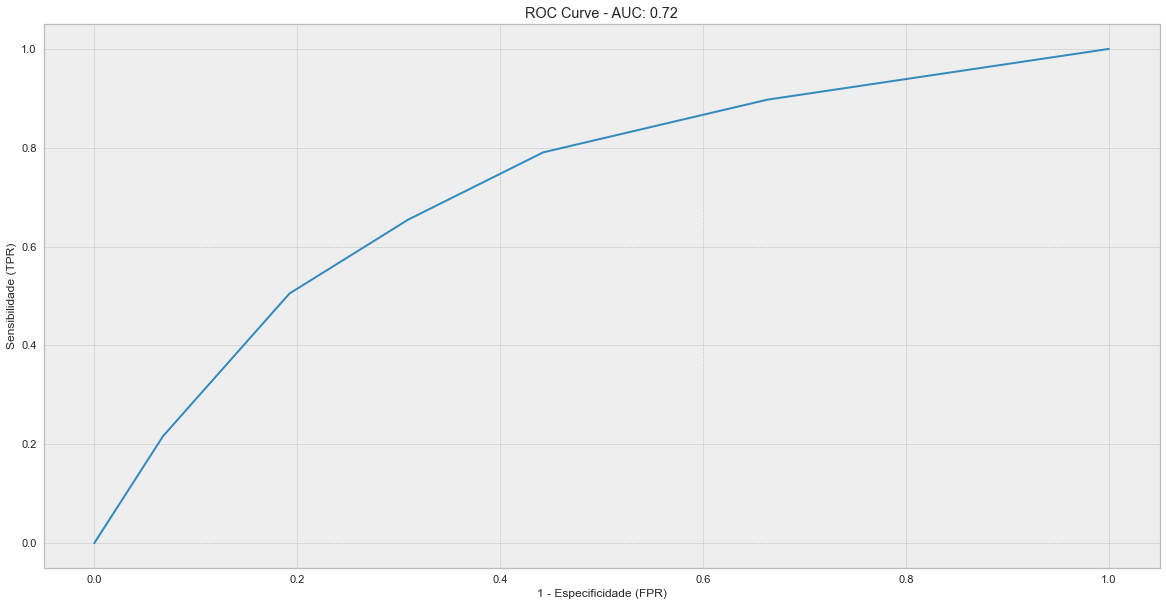

,Classifier Name,Tempo de execução (s):,Accuracy score,Precision score,Recall score,F1 score,Specificity,NPV,Balanced Accuracy score,AUC,Kappa score,Matthews Correlation Coefficient
0,KNN,1.144289,0.68,0.42,0.65,0.51,0.69,0.85,0.67,0.72,0.29,0.31


In [469]:
knn_result = test_dataset_metrics(X_df_test, y_test, knn, 'KNN')
knn_result

## 13.4 Logistic Regression Classifier

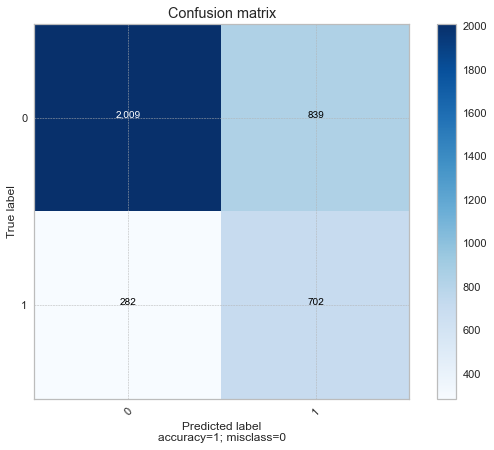

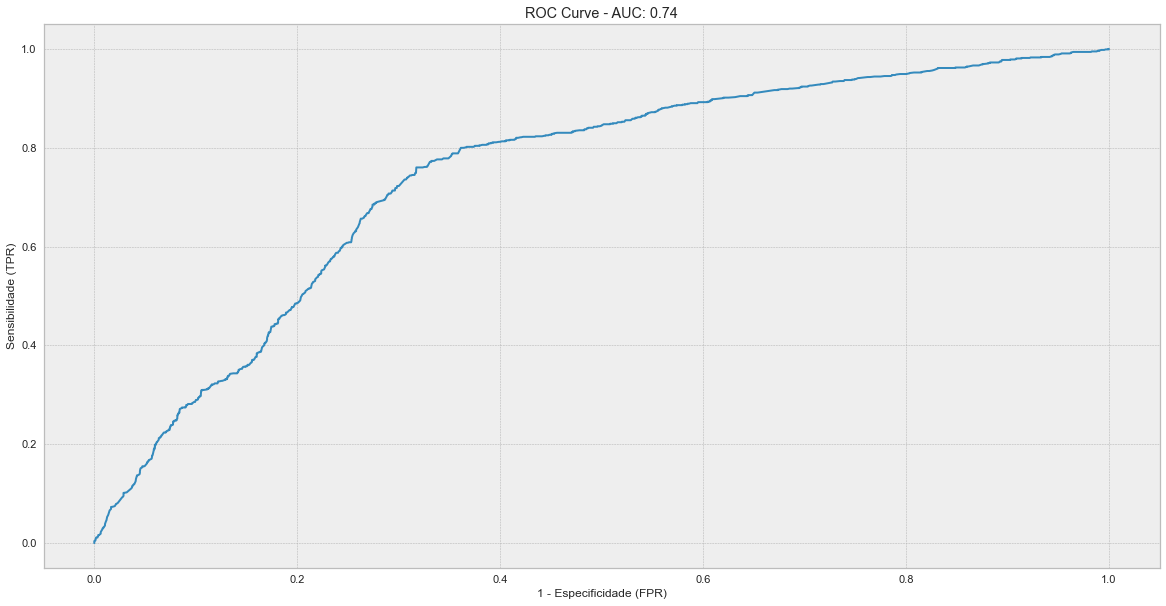

,Classifier Name,Tempo de execução (s):,Accuracy score,Precision score,Recall score,F1 score,Specificity,NPV,Balanced Accuracy score,AUC,Kappa score,Matthews Correlation Coefficient
0,Logistic Regression,0.464007,0.71,0.46,0.71,0.56,0.71,0.88,0.71,0.74,0.35,0.37


In [470]:
lr_result = test_dataset_metrics(X_df_test, y_test, lr, 'Logistic Regression')
lr_result

## 13.5 Support Vector Machine Classifier

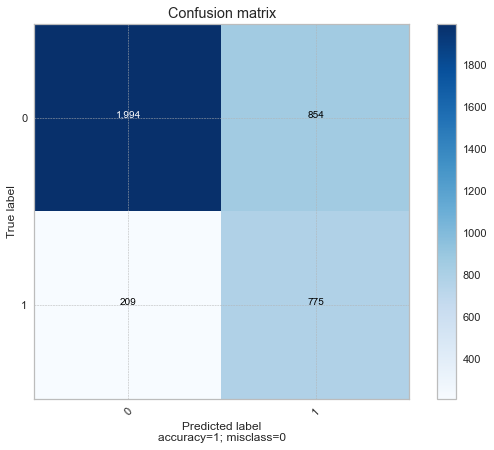

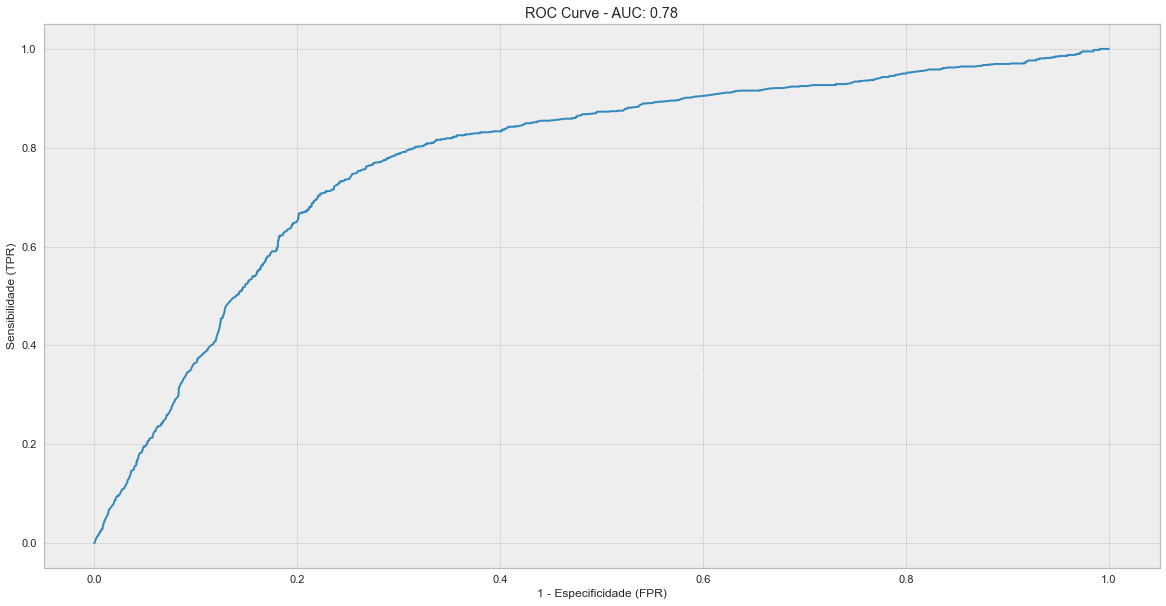

,Classifier Name,Tempo de execução (s):,Accuracy score,Precision score,Recall score,F1 score,Specificity,NPV,Balanced Accuracy score,AUC,Kappa score,Matthews Correlation Coefficient
0,SVM,3.316231,0.72,0.48,0.79,0.59,0.7,0.91,0.74,0.78,0.4,0.43


In [471]:
svm_result = test_dataset_metrics(X_df_test, y_test, svm, 'SVM')
svm_result

## 13.6 Neural Network Classifier

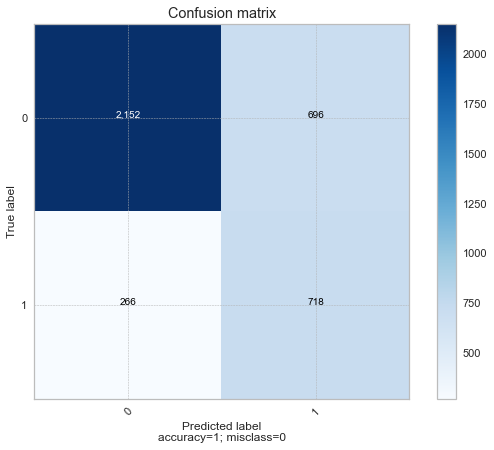

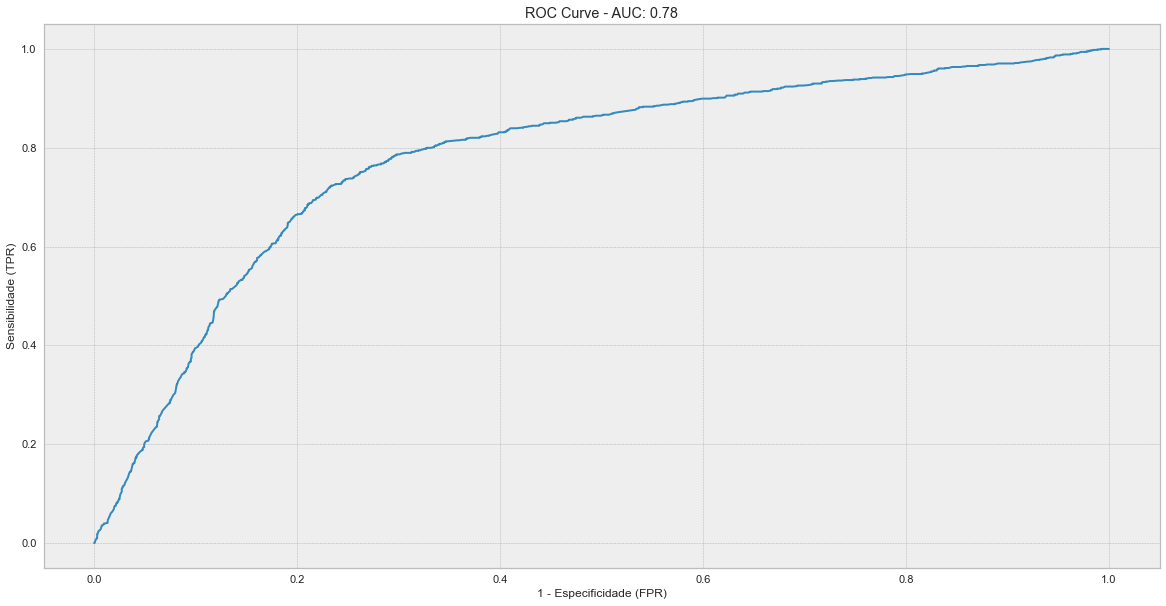

,Classifier Name,Tempo de execução (s):,Accuracy score,Precision score,Recall score,F1 score,Specificity,NPV,Balanced Accuracy score,AUC,Kappa score,Matthews Correlation Coefficient
0,Neural Network,0.633708,0.75,0.51,0.73,0.6,0.76,0.89,0.74,0.78,0.42,0.44


In [472]:
mlp_result = test_dataset_metrics(X_df_test, y_test, mlp, 'Neural Network')
mlp_result

## 13.7 Random Forest Classifier

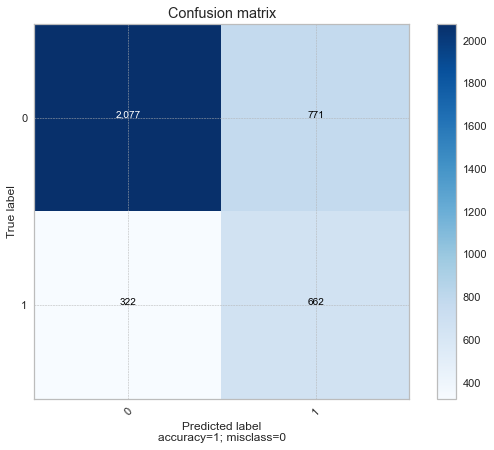

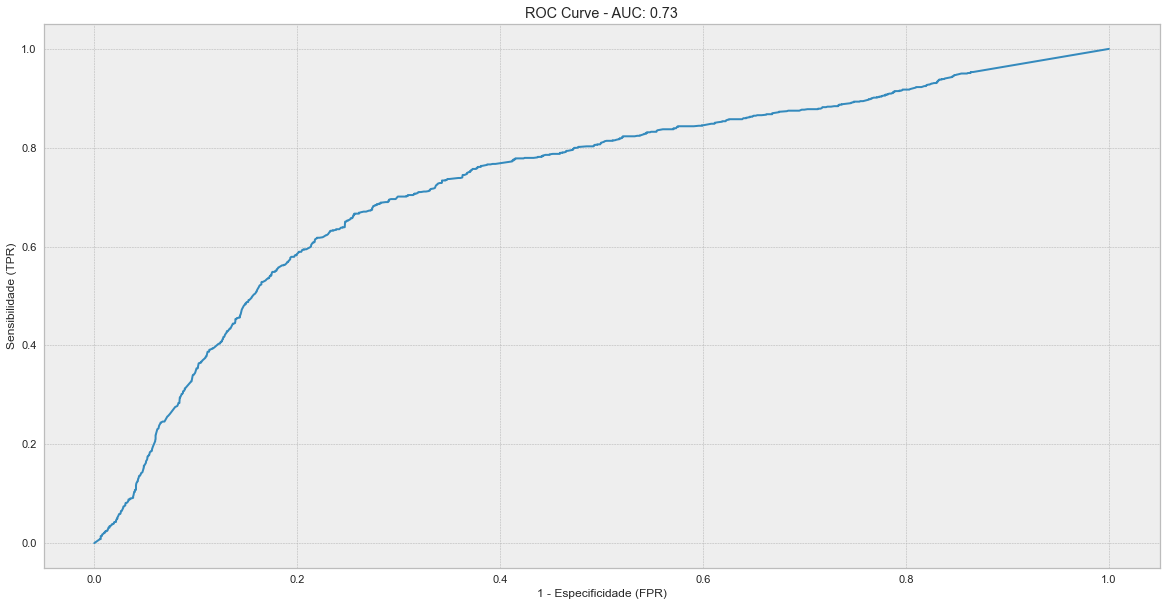

,Classifier Name,Tempo de execução (s):,Accuracy score,Precision score,Recall score,F1 score,Specificity,NPV,Balanced Accuracy score,AUC,Kappa score,Matthews Correlation Coefficient
0,Random Forest,0.566124,0.71,0.46,0.67,0.55,0.73,0.87,0.7,0.73,0.35,0.36


In [473]:
rf_result = test_dataset_metrics(X_df_test, y_test, rf, 'Random Forest')
rf_result

## 13.8 XGBoost Classifier

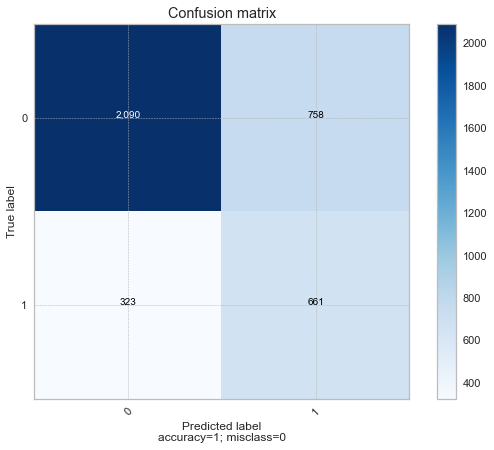

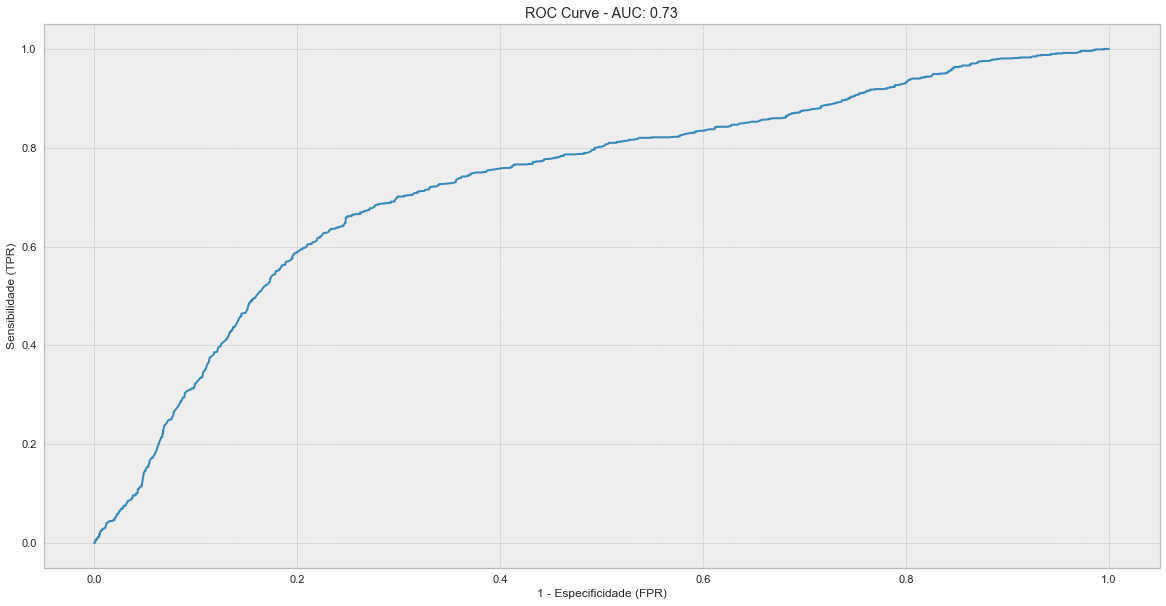

,Classifier Name,Tempo de execução (s):,Accuracy score,Precision score,Recall score,F1 score,Specificity,NPV,Balanced Accuracy score,AUC,Kappa score,Matthews Correlation Coefficient
0,XG Boost,0.532569,0.72,0.47,0.67,0.55,0.73,0.87,0.7,0.73,0.35,0.37


In [474]:
xgb_result = test_dataset_metrics(X_df_test, y_test, xgb_model, 'XG Boost')
xgb_result

## 13.9 XGBoostRF Classifier

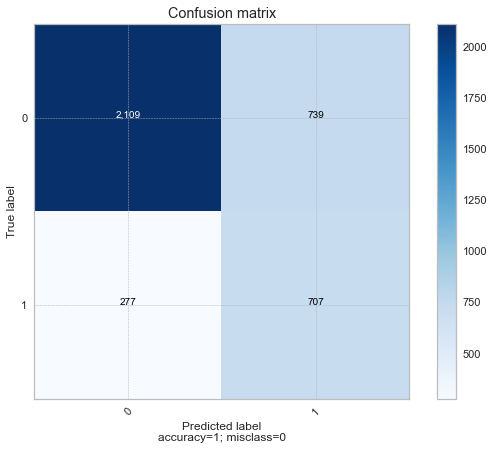

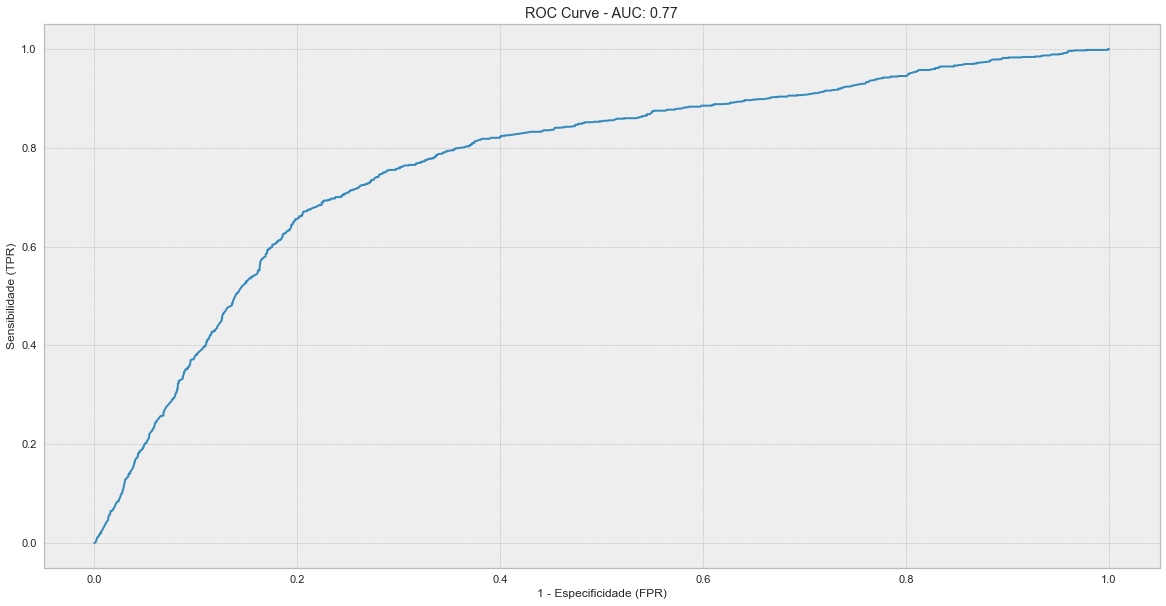

,Classifier Name,Tempo de execução (s):,Accuracy score,Precision score,Recall score,F1 score,Specificity,NPV,Balanced Accuracy score,AUC,Kappa score,Matthews Correlation Coefficient
0,XG Bosst RF,0.475698,0.73,0.49,0.72,0.58,0.74,0.88,0.73,0.77,0.4,0.41


In [475]:
xgbrf_result = test_dataset_metrics(X_df_test, y_test, xgbrf_model, 'XG Bosst RF')
xgbrf_result

## 13.10 Real Model´s Performance

In [476]:
model_result = pd.concat([nb_result, dt_result, knn_result, lr_result, svm_result, mlp_result, rf_result, xgb_result, xgbrf_result]).reset_index()
model_result.sort_values(by='Accuracy score',  ascending=False)

,index,Classifier Name,Tempo de execução (s):,Accuracy score,Precision score,Recall score,F1 score,Specificity,NPV,Balanced Accuracy score,AUC,Kappa score,Matthews Correlation Coefficient
5,0,Neural Network,0.633708,0.75,0.51,0.73,0.6,0.76,0.89,0.74,0.78,0.42,0.44
8,0,XG Bosst RF,0.475698,0.73,0.49,0.72,0.58,0.74,0.88,0.73,0.77,0.4,0.41
1,0,Decision Tree,0.582693,0.72,0.47,0.67,0.55,0.74,0.87,0.71,0.71,0.36,0.37
4,0,SVM,3.316231,0.72,0.48,0.79,0.59,0.7,0.91,0.74,0.78,0.4,0.43
7,0,XG Boost,0.532569,0.72,0.47,0.67,0.55,0.73,0.87,0.7,0.73,0.35,0.37
3,0,Logistic Regression,0.464007,0.71,0.46,0.71,0.56,0.71,0.88,0.71,0.74,0.35,0.37
6,0,Random Forest,0.566124,0.71,0.46,0.67,0.55,0.73,0.87,0.7,0.73,0.35,0.36
0,0,Naive Bayes,0.468045,0.69,0.43,0.63,0.51,0.71,0.85,0.67,0.73,0.29,0.3
2,0,KNN,1.144289,0.68,0.42,0.65,0.51,0.69,0.85,0.67,0.72,0.29,0.31


# 14.0 MODEL TRANSLATION AND INTERPRETATION

## 14.1 Data Loading

In [713]:
# load data
df_to_predict = pd.read_csv('aug_test.csv')
df_answer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 13 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   fe_cdi                                       2129 non-null   int64  
 1   fe_enrolled_university                       2129 non-null   int32  
 2   fe_education_level                           2129 non-null   int64  
 3   fe_experience                                2129 non-null   int64  
 4   fe_company_size                              2129 non-null   int64  
 5   fe_last_new_job                              2129 non-null   int64  
 6   relevent_experience_has_relevent_experience  2129 non-null   uint8  
 7   relevent_experience_no_relevent_experience   2129 non-null   uint8  
 8   fe_company_type_other                        2129 non-null   uint8  
 9   fe_company_type_pvt_ltd                      2129 non-null   uint8  
 10  

## 14.2 Data PreProcessing

### Treating missing values

In [714]:
# company_type
df_to_predict['company_type'].fillna('Unknown', inplace = True)

# company_size
df_to_predict['company_size'].fillna('Unknown', inplace = True)

# gender, replace the missing value by the most frequent value
df_to_predict['gender'].fillna(df_to_predict['gender'].mode()[0], inplace = True)

# major_discipline, replace the missing value by the most frequent value
df_to_predict['major_discipline'].fillna(df_to_predict['major_discipline'].mode()[0], inplace = True)

# education_level, replace the missing value by the most frequent value
df_to_predict['education_level'].fillna(df_to_predict['education_level'].mode()[0], inplace = True)

# last_new_job, replace the missing value by the most frequent value
df_to_predict['last_new_job'].fillna(df_to_predict['last_new_job'].mode()[0], inplace = True)

# enrolled_university, replace the missing value by the most frequent value
df_to_predict['enrolled_university'].fillna(df_to_predict['enrolled_university'].mode()[0], inplace = True)

# experience, replace the missing value by the most frequent value
df_to_predict['experience'].fillna(df_to_predict['experience'].mode()[0], inplace = True)

## 14.3 Feature Engineering

In [715]:
#cria classes , baseado nos quartis
df_to_predict['fe_cdi'] = df_to_predict['city_development_index'].apply( lambda x: 1 if x<=0.740000 else 2 if x<=0.903000 else 3 if x<=0.920000 else 4)
df_to_predict['fe_training_hours'] = df_to_predict['training_hours'].apply( lambda x: 1 if x<=23.000000 else 2 if x<=47.000000 else 3 if x<=88.000000 else 4)

df_to_predict[['city_development_index', 'fe_cdi', 'training_hours', 'fe_training_hours']].head()

,city_development_index,fe_cdi,training_hours,fe_training_hours
0,0.827,2,21,1
1,0.920,3,98,4
2,0.624,1,15,1
3,0.827,2,39,2
4,0.920,3,72,3


In [728]:
df_to_predict.head()

,fe_cdi,fe_enrolled_university,fe_education_level,fe_experience,fe_company_size,fe_last_new_job,relevent_experience_has_relevent_experience,relevent_experience_no_relevent_experience,fe_company_type_other,fe_company_type_pvt_ltd,fe_company_type_unknown,prediction,vl_recrutamento
0,2,1,2,2,1,1,1,0,0,0,1,0.0,2500
1,3,0,2,1,3,1,1,0,0,1,0,0.0,2500
2,1,0,1,4,3,0,0,1,0,1,0,0.0,2500
3,2,0,3,3,3,1,1,0,0,1,0,0.0,2500
4,3,0,2,4,3,3,1,0,0,1,0,0.0,2500


In [717]:
df_to_predict.drop(['enrollee_id', 'city', 'city_development_index', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job', 'training_hours'], axis=1, inplace=True)

## 14.4 Data Transformation

In [729]:
cat_attributes = list(df_to_predict.select_dtypes(['object']).columns) #df_to_predict.select_dtypes( include=['object', 'category'] )

for col in cat_attributes:
    df_to_predict[col] = df_to_predict[col].apply(lambda x: x.replace(' ', '_').lower() )
df_to_predict.head()

,fe_cdi,fe_enrolled_university,fe_education_level,fe_experience,fe_company_size,fe_last_new_job,relevent_experience_has_relevent_experience,relevent_experience_no_relevent_experience,fe_company_type_other,fe_company_type_pvt_ltd,fe_company_type_unknown,prediction,vl_recrutamento
0,2,1,2,2,1,1,1,0,0,0,1,0.0,2500
1,3,0,2,1,3,1,1,0,0,1,0,0.0,2500
2,1,0,1,4,3,0,0,1,0,1,0,0.0,2500
3,2,0,3,3,3,1,1,0,0,1,0,0.0,2500
4,3,0,2,4,3,3,1,0,0,1,0,0.0,2500


In [719]:
df_to_predict = pd.get_dummies(df_to_predict, columns=cat_attributes)
df_to_predict.head()

,fe_cdi,fe_training_hours,fe_enrolled_university,fe_education_level,fe_experience,fe_company_size,fe_last_new_job,gender_female,gender_male,gender_other,relevent_experience_has_relevent_experience,relevent_experience_no_relevent_experience,fe_major_discipline_other,fe_major_discipline_stem,fe_company_type_other,fe_company_type_pvt_ltd,fe_company_type_unknown
0,2,1,1,2,2,1,1,0,1,0,1,0,0,1,0,0,1
1,3,4,0,2,1,3,1,1,0,0,1,0,0,1,0,1,0
2,1,1,0,1,4,3,0,0,1,0,0,1,0,1,0,1,0
3,2,2,0,3,3,3,1,0,1,0,1,0,0,1,0,1,0
4,3,3,0,2,4,3,3,0,1,0,1,0,0,1,0,1,0


In [720]:
df_to_predict.drop(['fe_training_hours', 'fe_major_discipline_stem', 'fe_major_discipline_other', 'gender_male', 'gender_female', 'gender_other'], axis=1, inplace=True)

## 14.5 Prediction

In [721]:
# prediction
y_pred  = dtc.predict(df_to_predict)
#y_proba = dtc.predict_proba(df_to_predict)
df_to_predict['prediction'] = y_pred

## 14.6 Model translation and interpretation

### 14.6.1 Modelo Atual

In [756]:
qtde_candidatos = len(df_to_predict)
vl_recrutamento = 2500
lst_atual_model = [{'Indicadores': 'Banco de Talentos (Qtde)', 'Valor': '{:,.0f}'.format(qtde_candidatos ) },
                   {'Indicadores': 'Valor Médio de um Recrutamento', 'Valor': 'R$ {:,.2f}'.format( vl_recrutamento) },
                   {'Indicadores': 'Valor de Recrutamento Total', 'Valor': 'R$ {:,.2f}'.format( qtde_candidatos*vl_recrutamento ) },
                   {'Indicadores': 'Perda Financeira', 'Valor': 'R$ {:,.2f}'.format( (qtde_candidatos*vl_recrutamento)*0.75) } ]

df_atual = pd.DataFrame (lst_atual_model)
print('\n== Modelo Atual ============================')
df_atual


== Modelo Atual ============================


,Indicadores,Valor
0,Banco de Talentos (Qtde),"2,129"
1,Valor Médio de um Recrutamento,"R$ 2,500.00"
2,Valor de Recrutamento Total,"R$ 5,322,500.00"
3,Perda Financeira,"R$ 3,991,875.00"


### 14.6.2 Modelo Baseado em I.A

In [809]:
model_accuracy    = .78
predict_agg_count = df_to_predict[['prediction', 'vl_recrutamento']].groupby('prediction').size().to_frame('cand_count').reset_index()
no_job_change     = pd.Series( predict_agg_count.loc[ predict_agg_count['prediction']==0, 'cand_count' ] )
job_change        = pd.Series( predict_agg_count.loc[ predict_agg_count['prediction']==1, 'cand_count' ] )

lst_ia_model = [{'Indicadores': 'Banco de Talentos (Qtde)',                  'Qtde': qtde_candidatos,  'Valor': 'R$ {:,.2f}'.format(qtde_candidatos*vl_recrutamento ) },
                {'Indicadores': 'Classificados como não mudarão de emprego', 'Qtde': no_job_change[0], 'Valor': 'R$ {:,.2f}'.format( no_job_change[0]*vl_recrutamento ) },
                {'Indicadores': 'Classificados como mudarão de emprego',     'Qtde': job_change[1],    'Valor': 'R$ {:,.2f}'.format( job_change[1]*vl_recrutamento ) },
                {'Indicadores': 'Acerto Atual do Modelo 78%',                'Qtde': job_change[1]*model_accuracy,  'Valor': 'R$ {:,.2f}'.format( ( job_change[1]*model_accuracy*vl_recrutamento)) },
                {'Indicadores': 'Perda Financeira',                          'Qtde': '',               'Valor': 'R$ {:,.2f}'.format( (job_change[1]*vl_recrutamento) - ( job_change[1]*model_accuracy*vl_recrutamento) ) }, ]

df_ia_model = pd.DataFrame (lst_ia_model)
print('\n== Modelo Baseado em I.A ============================')
df_ia_model


== Modelo Baseado em I.A ============================


,Indicadores,Qtde,Valor
0,Banco de Talentos (Qtde),2129,"R$ 5,322,500.00"
1,Classificados como não mudarão de emprego,1321,"R$ 3,302,500.00"
2,Classificados como mudarão de emprego,808,"R$ 2,020,000.00"
3,Acerto Atual do Modelo 78%,630.24,"R$ 1,575,600.00"
4,Perda Financeira,,"R$ 444,400.00"


# 15.0 NEXT STEPS

## 15.1 Hyperparameter Fine Tunning

## 15.2 Melhorar a categorização das variáveis

## 15.3 Testar o modelo com dados escalonados.